# PrApp analysis

## Packages

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne
from statsmodels.stats.multitest import multipletests
from joblib import dump, load
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import log_loss
from kneefinder import KneeFinder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
import matplotlib.patches as mpatches

## Data

In [7]:
#   read preprocessed PrApp Data
PrEP = pd.read_csv('data/PrEP_filtered.csv', index_col = 0) 
no_PrEP = pd.read_csv('data/no_PrEP_filtered.csv', index_col =0) 

## Filtering for PrEP-indication
### Non-PrEP users with PrEP-indication

**Filter criteria for PrEP-indication (at least one criterion met)**
- sexualized drug use in the last 6 months
- STI in the last 12 months (syphilis, gonorrhoea, chlamydia, hepatitis C)
- ≥ 2 sex partners in the last 6 months AND low condom use (0-50%)

Steps
- Total number of non-PrEP users (preprocessed): 1,420 
- Non-PrEP users with PrEP indication: 431 
- Non-PrEP users without PrEP indication: 989


In [11]:
print(f'Number of non-PrEP users (preprocessed): {no_PrEP.shape[0]}')

no_PrEP_indication = no_PrEP.loc[(no_PrEP['ALL_DRUGS'] == 'Ja') |                                                           # drugs during sex       
                                 ((no_PrEP['ALL_TESTSYPH_FREQ'] == '1') |  (no_PrEP['ALL_TESTSYPH_FREQ']  == '2+')) |       # STI: Syphilis
                                 ((no_PrEP['ALL_TESTGO_FREQ'] == '1') |  (no_PrEP['ALL_TESTGO_FREQ']  == '2+')) |           # STI: Gonorrhö 
                                 ((no_PrEP['ALL_TESTCHLA_FREQ'] == '1') |  (no_PrEP['ALL_TESTCHLA_FREQ']  == '2+')) |       # STI: Chlamydien 
                                 (no_PrEP['ALL_TESTHCV_FREQ'] == 1.0) |                                                     # STI: Hepatitis 
                                 (((no_PrEP['ALL_SEXPARTNER'] == '2-3') |                                                   # 2+ sex partners in the last 6 months 
                                  (no_PrEP['ALL_SEXPARTNER'] == '4-5') | 
                                  (no_PrEP['ALL_SEXPARTNER'] == '6-10') |
                                  (no_PrEP['ALL_SEXPARTNER'] == '11-20') |
                                  (no_PrEP['ALL_SEXPARTNER'] == '>20')) &
                                  ((no_PrEP['ALL_KONDOM'] == '0%') |                                                        # AND low condom use (0-50%)
                                   (no_PrEP['ALL_KONDOM'] == '25%') |
                                   (no_PrEP['ALL_KONDOM'] == '50%')))]  
print(f'Number of non-PrEP users with PrEP-indication: {no_PrEP_indication.shape[0]}')

no_PrEP_remaining = no_PrEP.loc[~no_PrEP.index.isin(no_PrEP_indication.index)] 
print(f'Number of non-PrEP users without PrEP-indication: {no_PrEP_remaining.shape[0]}')

Number of non-PrEP users (preprocessed): 1420
Number of non-PrEP users with PrEP-indication: 431
Number of non-PrEP users without PrEP-indication: 989


### PrEP users with PrEP-indication

**Filter criteria for PrEP-indication (at least one criterion met)**
- drugs during sex in the last 6 months
- STI in the last 12 months (syphilis, gonorrhoea, chlamydia, hepatitis C)
- ≥ 2 sex partners in the last 6 months 

Steps
- Total number of PrEP users (preprocessed): 1,061 
- PrEP users with PrEP-indication: 1,027 
- PrEP users without PrEP-indication: 34

In [13]:
print(f'Number of PrEP users (preprocessed): {PrEP.shape[0]}')

PrEP_indication = PrEP.loc[(PrEP['ALL_DRUGS'] == 'Ja') |                                                        # drugs during sex 
                           ((PrEP['ALL_TESTSYPH_FREQ'] == '1') |  (PrEP['ALL_TESTSYPH_FREQ']  == '2+')) |       # STI: Syphilis
                           ((PrEP['ALL_TESTGO_FREQ'] == '1') |  (PrEP['ALL_TESTGO_FREQ']  == '2+')) |           # STI: Gonorrhö 
                           ((PrEP['ALL_TESTCHLA_FREQ'] == '1') |  (PrEP['ALL_TESTCHLA_FREQ']  == '2+')) |       # STI: Chlamydien 
                           (PrEP['ALL_TESTHCV_FREQ'] == 1.0) |                                                  # STI: Hepatitis 
                           ((PrEP['ALL_SEXPARTNER'] == '2-3') |                                                 # 2+ sex partners in the last 6 months
                            (PrEP['ALL_SEXPARTNER'] == '4-5') | 
                            (PrEP['ALL_SEXPARTNER'] == '6-10') |
                            (PrEP['ALL_SEXPARTNER'] == '11-20') |
                            (PrEP['ALL_SEXPARTNER'] == '>20'))]    
print(f'Number of PrEP users with PrEP-indication: {PrEP_indication.shape[0]}')

PrEP_remaining = PrEP.loc[~PrEP.index.isin(PrEP_indication.index)] 
print(f'Number of PrEP users without PrEP-indication: {PrEP_remaining.shape[0]}')

Number of PrEP users (preprocessed): 1061
Number of PrEP users with PrEP-indication: 1027
Number of PrEP users without PrEP-indication: 34


### Stratification by survey wave 

- Non-PrEP users with PrEP-indication: 431 (wave 3: 349 and wave 4: 82)
- Non-PrEP users without PrEP-indication: 989 (wave 3: 772 and wave 4: 217)

- PrEP users with PrEP-indication: 1,027 (wave 3: 759 and wave 4: 268)
- PrEP users without PrEP-indication: 34 (wave 3: 22 and wave 4: 12)

In [12]:
no_PrEP_indication_counts = no_PrEP_indication['welle'].value_counts()
no_PrEP_remaining_counts = no_PrEP_remaining['welle'].value_counts()
PrEP_indication_counts = PrEP_indication['welle'].value_counts()
PrEP_remaining_counts = PrEP_remaining['welle'].value_counts()

filtered_participants_by_wave = pd.DataFrame({
    'no_PrEP_indication': no_PrEP_indication_counts,
    'no_PrEP_remaining': no_PrEP_remaining_counts,
    'PrEP_indication': PrEP_indication_counts,
    'PrEP_remaining': PrEP_remaining_counts
})
filtered_participants_by_wave 

,no_PrEP_indication,no_PrEP_remaining,PrEP_indication,PrEP_remaining
welle,,,,
3.0,349,772,759,22
4.0,82,217,268,12


### Subgroups in non-PrEP users with PrEP-indication 
**Two subgroups in non-PrEP users with PrEP-indication (n = 431)**
- PrEP-indication induced by sexualized drug use: 130
- PrEP-indication induced by sexual behaviour (two or more sexual partner AND low condom use) and/or STI: 364

no exclusive groups: 63 participants are in both groups (have a PrEP-indication due to sexual behaviour/STI and sexualized drug use)

In [18]:
# Non-PrEP users with a PrEP-indication due to their sexualized drug use in the last 6 months (n = 130)
no_PrEP_drug = no_PrEP_indication.loc[(no_PrEP_indication['ALL_DRUGS'] == 'Ja')] 
print(f'Number of PrEP users with PrEP-indication due to their sexualized drug use in the last 6 months: {no_PrEP_drug.shape[0]}')

# Non-PrEP users with a PrEP-indication due to a STI in the last 12 months (n = 143)
no_PrEP_STI = no_PrEP_indication.loc[((no_PrEP['ALL_TESTSYPH_FREQ'] == '1') |  (no_PrEP['ALL_TESTSYPH_FREQ']  == '2+')) |        # STI: Syphilis
                                      ((no_PrEP['ALL_TESTGO_FREQ'] == '1') |  (no_PrEP['ALL_TESTGO_FREQ']  == '2+')) |           # STI: Gonorrhö 
                                      ((no_PrEP['ALL_TESTCHLA_FREQ'] == '1') |  (no_PrEP['ALL_TESTCHLA_FREQ']  == '2+')) |       # STI: Chlamydien 
                                      (no_PrEP['ALL_TESTHCV_FREQ'] == 1.0) ]                                                     # STI: Hepatitis C
print(f'Number of non-PrEP users with PrEP-indication due to a STI in the last 12 months: {no_PrEP_STI.shape[0]}')

# Non-PrEP users with a PrEP-indication due to their sexual behaviour (n = 266)
# sexual behaviour: two or more sexual partners in the last 6 months and low condom use (0-50%)
no_PrEP_sex = no_PrEP_indication.loc[(((no_PrEP_indication['ALL_SEXPARTNER'] == '2-3') |              
                                       (no_PrEP_indication['ALL_SEXPARTNER'] == '4-5') | 
                                       (no_PrEP_indication['ALL_SEXPARTNER'] == '6-10') |
                                       (no_PrEP_indication['ALL_SEXPARTNER'] == '11-20') |
                                       (no_PrEP_indication['ALL_SEXPARTNER'] == '>20')) &
                                       ((no_PrEP_indication['ALL_KONDOM'] == '0%') |                  
                                        (no_PrEP_indication['ALL_KONDOM'] == '25%') |
                                        (no_PrEP_indication['ALL_KONDOM'] == '50%')))]  
print(f'Number of non-PrEP users with PrEP-indication due to their sexual behaviour in the last 6 months: {no_PrEP_sex.shape[0]}')

# Non-PrEP users with a PrEP-indication due to their sexual behaviour and/or STI history (n = 364)
no_PrEP_STI_and_sex = no_PrEP_indication.loc[(((no_PrEP['ALL_TESTSYPH_FREQ'] == '1') |  (no_PrEP['ALL_TESTSYPH_FREQ']  == '2+')) |        
                                             ((no_PrEP['ALL_TESTGO_FREQ'] == '1') | (no_PrEP['ALL_TESTGO_FREQ']  == '2+')) |           
                                             ((no_PrEP['ALL_TESTCHLA_FREQ'] == '1') |  (no_PrEP['ALL_TESTCHLA_FREQ']  == '2+')) |       
                                             (no_PrEP['ALL_TESTHCV_FREQ'] == 1.0))  |      
                                             (((no_PrEP_indication['ALL_SEXPARTNER'] == '2-3') |    
                                               (no_PrEP_indication['ALL_SEXPARTNER'] == '4-5') | 
                                               (no_PrEP_indication['ALL_SEXPARTNER'] == '6-10') |
                                               (no_PrEP_indication['ALL_SEXPARTNER'] == '11-20') |
                                               (no_PrEP_indication['ALL_SEXPARTNER'] == '>20')) &
                                               ((no_PrEP_indication['ALL_KONDOM'] == '0%') |        
                                                (no_PrEP_indication['ALL_KONDOM'] == '25%') |
                                                (no_PrEP_indication['ALL_KONDOM'] == '50%')))]  
print(f'Number of non-PrEP users with PrEP-indication due to their sexual behaviour and/or STI history: {no_PrEP_STI_and_sex.shape[0]}')

# Non-PrEP users with a PrEP-indication due to their sexual behaviour and/or STI history AND sexualized drug use (n = 63)
common_indices = no_PrEP_STI_and_sex.index.intersection(no_PrEP_drug.index)
common_cases = no_PrEP_STI_and_sex.loc[common_indices] # 63 common participants
print(f'Number of non-PrEP users with PrEP-indication due to their sexual behaviour and/or STI history AND sexualized drug use: {common_cases.shape[0]}')

Number of PrEP users with PrEP-indication due to their sexualized drug use in the last 6 months: 130
Number of non-PrEP users with PrEP-indication due to a STI in the last 12 months: 143
Number of non-PrEP users with PrEP-indication due to their sexual behaviour in the last 6 months: 266
Number of non-PrEP users with PrEP-indication due to their sexual behaviour and/or STI history: 364
Number of non-PrEP users with PrEP-indication due to their sexual behaviour and/or STI history AND sexualized drug use: 63


## Baseline summary

In [19]:
# concatenate PrEP and no PrEP for descriptive summary
concatenated_filtered_indication = pd.concat([PrEP_indication, no_PrEP_indication], ignore_index = True)

### Non-PrEP users vs. PrEP users by PrEP-indication criteria 


In [20]:
data_filter_criteria = concatenated_filtered_indication[['ALL_DRUGS', 'ALL_TESTSYPH_FREQ', 'ALL_TESTGO_FREQ', 
                                                         'ALL_TESTCHLA_FREQ','ALL_TESTHCV_FREQ', 'ALL_KONDOM', 
                                                         'ALL_SEXPARTNER','status']].copy() # PrEP-indication criteria

data_filter_criteria = data_filter_criteria.astype('category')
columns_filter_criteria = ['ALL_DRUGS', 'ALL_TESTSYPH_FREQ', 'ALL_TESTGO_FREQ', 'ALL_TESTCHLA_FREQ',
                           'ALL_TESTHCV_FREQ', 'ALL_KONDOM', 'ALL_SEXPARTNER']
categorical_filter_criteria = ['ALL_DRUGS', 'ALL_TESTSYPH_FREQ', 'ALL_TESTGO_FREQ', 'ALL_TESTCHLA_FREQ',
                           'ALL_TESTHCV_FREQ', 'ALL_KONDOM', 'ALL_SEXPARTNER']
null_value = 'None'
for col in categorical_filter_criteria:
    data_filter_criteria[col] = data_filter_criteria[col].cat.add_categories(null_value)

rename_filter_criteria = {'ALL_TESTSYPH_FREQ': 'Syphilis diagnosis in the last 12 months',
                          'ALL_TESTGO_FREQ': 'Gonorrhoea diagnosis in the last 12 months', 
                          'ALL_TESTCHLA_FREQ': 'Chlamydia diagnosis in the last 12 months', 
                          'ALL_TESTHCV_FREQ': 'Hepatitis C diagnosis in the last 12 months', 
                          'ALL_DRUGS': 'Drugs during sex in the last 6 months',
                          'ALL_KONDOM': 'Condom use',
                          'ALL_SEXPARTNER': 'Sexual partners in the last 6 months'}
table_filter_criteria = TableOne(data_filter_criteria, columns = columns_filter_criteria, 
                                 categorical = categorical_filter_criteria, rename = rename_filter_criteria, 
                                 groupby = 'status', pval = False, missing = False) 

print(table_filter_criteria.tabulate(tablefmt = "fancy grid")) 

                                                           Overall      current PrEP    no PrEP
--------------------------------------------------  -----  -----------  --------------  ----------
n                                                          1458         1027            431
Drugs during sex in the last 6 months, n (%)        Ja     331 (22.7)   201 (19.6)      130 (30.2)
                                                    Nein   1097 (75.2)  808 (78.7)      289 (67.1)
                                                    None   30 (2.1)     18 (1.8)        12 (2.8)
Syphilis diagnosis in the last 12 months, n (%)     0      218 (15.0)   166 (16.2)      52 (12.1)
                                                    1      149 (10.2)   107 (10.4)      42 (9.7)
                                                    2+     13 (0.9)     11 (1.1)        2 (0.5)
                                                    None   1078 (73.9)  743 (72.3)      335 (77.7)
Gonorrhoea diagnosis in the 

/Users/waldo/helena/University/RKI/PrAppData/.venv/lib/python3.13/site-packages/tableone/preprocessors.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupbylvls = sorted(data.groupby(groupby).groups.keys())  # type: ignore


### Non-PrEP users vs. PrEP users (baseline characteristics)

In [21]:
data_table_baseline_summary = concatenated_filtered_indication.copy()

columns_baseline_summary  = ['ABSCHLUSS_TYPE', 'SEXLIFE', 'alter', 'ALL_SEXWITH_MEN',
                      'ALL_SEXWITH_WOMEN', 'ALL_SEXWITH_NONBINARY', 'ALL_SEXPARTNER',
                      'ALL_SEXFREQ', 'ALL_DRUGS', 'ALL_DRUGS_INJECT', 'ALL_SEXWORK',
                      'ALL_KONDOM', 'ALL_STI_SYMPTOM', 'ALL_TESTSTIPOS_SYPH_w3',
                      'ALL_TESTSTIPOS_GO_w3', 'ALL_TESTSTIPOS_CHLA_w3',
                      'ALL_TESTSTIPOS_HCV_w3', 'ALL_TESTSTIPOS_KEINE_w3', 'ALL_TESTSYPH_FREQ',
                      'ALL_TESTGO_FREQ', 'ALL_TESTCHLA_FREQ', 'ALL_TESTHCV_FREQ', 'landbin',
                      'NET_EQUIVALENT_INCOME', 'URBAN_RURAL_AREA',
                      'HIV_SPECIALIST_DENSITY']

categorical_baseline_summary  =  ['ABSCHLUSS_TYPE', 'SEXLIFE', 'alter', 'ALL_SEXWITH_MEN',
                                                'ALL_SEXWITH_WOMEN', 'ALL_SEXWITH_NONBINARY', 'ALL_SEXPARTNER',
                                                'ALL_SEXFREQ', 'ALL_DRUGS', 'ALL_DRUGS_INJECT', 'ALL_SEXWORK',
                                                'ALL_KONDOM', 'ALL_STI_SYMPTOM', 'ALL_TESTSTIPOS_SYPH_w3',
                                                'ALL_TESTSTIPOS_GO_w3', 'ALL_TESTSTIPOS_CHLA_w3',
                                                'ALL_TESTSTIPOS_HCV_w3', 'ALL_TESTSTIPOS_KEINE_w3', 'ALL_TESTSYPH_FREQ',
                                                'ALL_TESTGO_FREQ', 'ALL_TESTCHLA_FREQ', 'ALL_TESTHCV_FREQ', 'landbin',
                                                'NET_EQUIVALENT_INCOME', 'URBAN_RURAL_AREA',
                                                'HIV_SPECIALIST_DENSITY']


rename_baseline_summary = {'alter': 'Age', 'BL': 'Federal state of residence',
                     'landbin': 'Country of origin', 
                     'ALL_SEXPARTNER': 'Sexpartners in the last 6 months',
                     'ALL_KONDOM': 'Condom use',
                     'ABSCHLUSS': 'Type of school qualification',
                     'ABSCHLUSS_TYPE': 'General school qualification', 
                     'ALL_SEXFREQ': 'Number of sexual intercourses in the last month'}

table_baseline_summary = TableOne(data_table_baseline_summary, columns = columns_baseline_summary, categorical = categorical_baseline_summary, 

                                       rename = rename_baseline_summary, pval = False, groupby = 'status', missing = False)

print(table_baseline_summary.tabulate(tablefmt = "fancy grid"))
# print(table_baseline_summary.tabulate(tablefmt = "latex"))

                                                                                     Overall      current PrEP    no PrEP
------------------------------------------------------  ---------------------------  -----------  --------------  ----------
n                                                                                    1458         1027            431
General school qualification, n (%)                     Fachhochschulreife / Abitur  1064 (73.0)  776 (75.6)      288 (66.8)
                                                        Haupt-/Volksschulabschluss   69 (4.7)     49 (4.8)        20 (4.6)
                                                        Kein Abschluss               16 (1.1)     7 (0.7)         9 (2.1)
                                                        None                         15 (1.0)     5 (0.5)         10 (2.3)
                                                        Realschulabschluss           294 (20.2)   190 (18.5)      104 (24.1)
SEXLIFE, n (%)   

## Reasons for not taking PrEP
Reasons for not taking PrEP stratified by survey wave, by PrEP-indication and by low-vs-high HIV-specialists density

Test: Chi-Squared (or Fisher's exact)


#### stratified by low-vs-high HIV-specialists density

In [22]:
no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'] = np.where(
    no_PrEP_indication['HIV_SPECIALIST_DENSITY'].isin(["0", "1-2", "3-5", "6-9"]), '0-9',
    np.where(no_PrEP_indication['HIV_SPECIALIST_DENSITY'] == "10-13", '10-13', 'NaN'))

no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'] = np.where(
    no_PrEP_indication['HIV_SPECIALIST_DENSITY'].isna(), 'NaN', no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'])

no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'] = no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'].replace('NaN', np.nan)

/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/528235871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'] = np.where(
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/528235871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_PrEP_indication['HIV_SPECIALIST_DENSITY_grouped'] = np.where(
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/528235871.py:8: SettingWithCopyWarning: 
A value is trying to be s

In [23]:
data_reasons = no_PrEP_indication[['NO_PREPGRUND_C1_w3','NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C5_w3', 'NO_PREPGRUND_C8_w3',
                                    'NO_PREPGRUND_C9_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C3_w3', 'welle', 'URBAN_RURAL_AREA', 'HIV_SPECIALIST_DENSITY_grouped']].copy()
columns_reasons = ['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                   'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3']
categorical_reasons  = ['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                        'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3']
rename_reasons = {'NO_PREPGRUND_C1_w3':  'Personal HIV risk too low', 'NO_PREPGRUND_C3_w3': 'Medical reasons', 'NO_PREPGRUND_C4_w3': 'No doctor prescribing PrEP',
                   'NO_PREPGRUND_C5_w3': 'Not discussing my sex life with my doctor','NO_PREPGRUND_C6_w3': 'Too much effort: doctor visits + regular tests',
                   'NO_PREPGRUND_C7_w3': 'Daily pill too strenuous', 'NO_PREPGRUND_C8_w3': 'Fear: negative reactions from others/sex partners', 
                   'NO_PREPGRUND_C9_w3': 'Fear: side effects', 'welle': 'survey wave'}

order_reasons = {'NO_PREPGRUND_C1_w3': ['ja', 'nein'],'NO_PREPGRUND_C4_w3': ['ja', 'nein'], 'NO_PREPGRUND_C6_w3': ['ja', 'nein'], 'NO_PREPGRUND_C5_w3': ['ja', 'nein'], 
                 'NO_PREPGRUND_C8_w3': ['ja', 'nein'],'NO_PREPGRUND_C9_w3': ['ja', 'nein'], 'NO_PREPGRUND_C7_w3': ['ja', 'nein'], 'NO_PREPGRUND_C3_w3': ['ja', 'nein']}

In [24]:
# no correction for multiple testing 
table_reason_vs_density = TableOne(data_reasons, columns = columns_reasons , categorical = categorical_reasons, 
                   rename = rename_reasons, groupby = 'HIV_SPECIALIST_DENSITY_grouped', pval = True, htest_name = True, missing=False, order = order_reasons)

print(table_reason_vs_density.tabulate(tablefmt = "fancy grid")) 

                                                                Overall     0-9         10-13      P-Value    Test
--------------------------------------------------------  ----  ----------  ----------  ---------  ---------  --------------
n                                                               431         332         81
Personal HIV risk too low, n (%)                          ja    110 (25.5)  80 (24.1)   29 (35.8)  0.045      Chi-squared
                                                          nein  321 (74.5)  252 (75.9)  52 (64.2)
Medical reasons, n (%)                                    ja    4 (0.9)     3 (0.9)     1 (1.2)    0.584      Fisher's exact
                                                          nein  427 (99.1)  329 (99.1)  80 (98.8)
No doctor prescribing PrEP, n (%)                         ja    88 (20.4)   70 (21.1)   12 (14.8)  0.266      Chi-squared
                                                          nein  343 (79.6)  262 (78.9)  69 (85.2)
Not di

In [25]:
# correction for multiple testing 
table_reason_vs_density.htest_table['P-value_corrected'] = multipletests(table_reason_vs_density.htest_table['P-Value'].values.flatten(), method = 'fdr_bh')[1]
table_reason_vs_density.htest_table

,continuous,nonnormal,min_observed,P-Value,Test,P-value_corrected
variable,,,,,,
NO_PREPGRUND_C1_w3,False,False,81,0.045226,Chi-squared,0.120603
NO_PREPGRUND_C3_w3,False,False,81,0.583895,Fisher's exact,0.583895
NO_PREPGRUND_C4_w3,False,False,81,0.26575,Chi-squared,0.305704
NO_PREPGRUND_C5_w3,False,False,81,0.020788,Chi-squared,0.083152
NO_PREPGRUND_C6_w3,False,False,81,0.199793,Chi-squared,0.305704
NO_PREPGRUND_C7_w3,False,False,81,0.267491,Chi-squared,0.305704
NO_PREPGRUND_C8_w3,False,False,81,0.255036,Chi-squared,0.305704
NO_PREPGRUND_C9_w3,False,False,81,0.01293,Chi-squared,0.083152


### stratified by survey wave 3 vs. 4

In [26]:
# no correction for multiple testing 
table_reason_vs_wave = TableOne(data_reasons, columns = columns_reasons , categorical = categorical_reasons, 
                   rename = rename_reasons, groupby = 'welle', pval = True, htest_name = True)

print(table_reason_vs_wave.tabulate(tablefmt = "fancy grid")) 

                                                                Missing    Overall     3.0         4.0        P-Value    Test
--------------------------------------------------------  ----  ---------  ----------  ----------  ---------  ---------  --------------
n                                                                          431         349         82
Personal HIV risk too low, n (%)                          ja               110 (25.5)  87 (24.9)   23 (28.0)  0.658      Chi-squared
                                                          nein             321 (74.5)  262 (75.1)  59 (72.0)
Medical reasons, n (%)                                    ja               4 (0.9)     3 (0.9)     1 (1.2)    0.571      Fisher's exact
                                                          nein             427 (99.1)  346 (99.1)  81 (98.8)
No doctor prescribing PrEP, n (%)                         ja               88 (20.4)   67 (19.2)   21 (25.6)  0.253      Chi-squared
                

In [27]:
table_reason_vs_wave.htest_table['P-value_corrected'] = multipletests(table_reason_vs_wave.htest_table['P-Value'].values.flatten(), method = 'fdr_bh')[1]
table_reason_vs_wave.htest_table

,continuous,nonnormal,min_observed,P-Value,Test,P-value_corrected
variable,,,,,,
NO_PREPGRUND_C1_w3,False,False,82,0.658152,Chi-squared,0.822169
NO_PREPGRUND_C3_w3,False,False,82,0.571488,Fisher's exact,0.822169
NO_PREPGRUND_C4_w3,False,False,82,0.252639,Chi-squared,0.673705
NO_PREPGRUND_C5_w3,False,False,82,0.0039,Chi-squared,0.031203
NO_PREPGRUND_C6_w3,False,False,82,0.015758,Chi-squared,0.063032
NO_PREPGRUND_C7_w3,False,False,82,0.895628,Chi-squared,0.895628
NO_PREPGRUND_C8_w3,False,False,82,0.719398,Chi-squared,0.822169
NO_PREPGRUND_C9_w3,False,False,82,0.491698,Chi-squared,0.822169


### stratified by PrEP indication subgroups

In [28]:
no_PrEP_drug.loc[:, 'INDICATION_SUBGROUP'] = 'sexualized drug-use'
no_PrEP_STI_and_sex.loc[:, 'INDICATION_SUBGROUP'] = 'sexual behaviour or STI'

common_indices = no_PrEP_STI_and_sex.index.intersection(no_PrEP_drug.index)
common_cases = no_PrEP_STI_and_sex.loc[common_indices] # 63 common participants # 63 common participants

no_PrEP_drug_both = no_PrEP_drug.copy()

# add both subgroup 
no_PrEP_drug_both.loc[
    no_PrEP_drug_both.index.isin(common_cases.index), 'INDICATION_SUBGROUP'] = 'both'

no_PrEP_drug_filtered = no_PrEP_drug[~no_PrEP_drug.index.isin(common_cases.index)]
no_PrEP_STI_and_sex_filtered = no_PrEP_STI_and_sex[~no_PrEP_STI_and_sex.index.isin(common_cases.index)]

concatenated_no_PrEP_indication_subgroups_filtered = pd.concat([no_PrEP_drug_filtered, no_PrEP_STI_and_sex_filtered], ignore_index = True)
concatenated_no_PrEP_indication_subgroups_both = pd.concat([no_PrEP_drug_both, no_PrEP_STI_and_sex_filtered], ignore_index = True)

/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/1472742892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_PrEP_drug.loc[:, 'INDICATION_SUBGROUP'] = 'sexualized drug-use'
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/1472742892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_PrEP_STI_and_sex.loc[:, 'INDICATION_SUBGROUP'] = 'sexual behaviour or STI'


#### exclusive groups

In [29]:
# exclusive groups 
data_reasons_subgroups = concatenated_no_PrEP_indication_subgroups_filtered[['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                                                                             'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3', 
                                                                             'INDICATION_SUBGROUP']].copy()
columns_reasons_subgroups = ['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                             'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3']
categorical_reasons_subgroups  = ['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                                  'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3']
rename_reasons_subgroups = {'NO_PREPGRUND_C1_w3':  'Personal HIV risk too low', 'NO_PREPGRUND_C3_w3': 'Medical reasons', 
                            'NO_PREPGRUND_C4_w3': 'No doctor prescribing PrEP',
                            'NO_PREPGRUND_C5_w3': 'Not discussing my sex life with my doctor',
                            'NO_PREPGRUND_C6_w3': 'Too much effort: doctor visits + regular tests',
                            'NO_PREPGRUND_C7_w3': 'Daily pill too strenuous', 
                            'NO_PREPGRUND_C8_w3': 'Fear: negative reactions from others/sex partners', 
                            'NO_PREPGRUND_C9_w3': 'Fear: side effects', 'welle': 'survey wave'}

table_reason_vs_subgroup = TableOne(data_reasons_subgroups, columns = columns_reasons_subgroups , categorical = categorical_reasons_subgroups, 
                                    rename = rename_reasons_subgroups, groupby = 'INDICATION_SUBGROUP', pval = True, htest_name = True, overall = False)

print(table_reason_vs_subgroup.tabulate(tablefmt = "fancy grid")) 

                                                                Missing    sexual behaviour or STI    sexualized drug-use    P-Value    Test
--------------------------------------------------------  ----  ---------  -------------------------  ---------------------  ---------  --------------
n                                                                          301                        67
Personal HIV risk too low, n (%)                          ja               75 (24.9)                  22 (32.8)              0.239      Chi-squared
                                                          nein             226 (75.1)                 45 (67.2)
Medical reasons, n (%)                                    ja               4 (1.3)                    0 (0.0)                1.000      Fisher's exact
                                                          nein             297 (98.7)                 67 (100.0)
No doctor prescribing PrEP, n (%)                         ja               55 (

In [30]:
table_reason_vs_subgroup.htest_table['P-value_corrected'] = multipletests(table_reason_vs_subgroup.htest_table['P-Value'].values.flatten(), method = 'fdr_bh')[1]
table_reason_vs_subgroup.htest_table

,continuous,nonnormal,min_observed,P-Value,Test,P-value_corrected
variable,,,,,,
NO_PREPGRUND_C1_w3,False,False,67,0.239089,Chi-squared,0.478178
NO_PREPGRUND_C3_w3,False,False,67,1.0,Fisher's exact,1.0
NO_PREPGRUND_C4_w3,False,False,67,0.745589,Chi-squared,0.994119
NO_PREPGRUND_C5_w3,False,False,67,0.332558,Chi-squared,0.532092
NO_PREPGRUND_C6_w3,False,False,67,0.043149,Chi-squared,0.16417
NO_PREPGRUND_C7_w3,False,False,67,0.002347,Chi-squared,0.018777
NO_PREPGRUND_C8_w3,False,False,67,0.061564,Fisher's exact,0.16417
NO_PREPGRUND_C9_w3,False,False,67,0.919785,Chi-squared,1.0


#### including both

In [31]:
# exclusive + both groups 
data_reasons_subgroups = concatenated_no_PrEP_indication_subgroups_both[['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                                                                             'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3', 
                                                                             'INDICATION_SUBGROUP']].copy()
columns_reasons_subgroups = ['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                             'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3']
categorical_reasons_subgroups  = ['NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C3_w3', 'NO_PREPGRUND_C4_w3', 'NO_PREPGRUND_C5_w3',
                                  'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C8_w3', 'NO_PREPGRUND_C9_w3']
rename_reasons_subgroups = {'NO_PREPGRUND_C1_w3':  'Personal HIV risk too low', 'NO_PREPGRUND_C3_w3': 'Medical reasons', 
                            'NO_PREPGRUND_C4_w3': 'No doctor prescribing PrEP',
                            'NO_PREPGRUND_C5_w3': 'Not discussing my sex life with my doctor',
                            'NO_PREPGRUND_C6_w3': 'Too much effort: doctor visits + regular tests',
                            'NO_PREPGRUND_C7_w3': 'Daily pill too strenuous', 
                            'NO_PREPGRUND_C8_w3': 'Fear: negative reactions from others/sex partners', 
                            'NO_PREPGRUND_C9_w3': 'Fear: side effects', 'welle': 'survey wave'}

table_reason_vs_subgroup = TableOne(data_reasons_subgroups, columns = columns_reasons_subgroups , categorical = categorical_reasons_subgroups, 
                                    rename = rename_reasons_subgroups, groupby = 'INDICATION_SUBGROUP')

print(table_reason_vs_subgroup.tabulate(tablefmt = "fancy grid")) 

                                                                Missing    Overall     both        sexual behaviour or STI    sexualized drug-use
--------------------------------------------------------  ----  ---------  ----------  ----------  -------------------------  ---------------------
n                                                                          431         63          301                        67
Personal HIV risk too low, n (%)                          ja               110 (25.5)  13 (20.6)   75 (24.9)                  22 (32.8)
                                                          nein             321 (74.5)  50 (79.4)   226 (75.1)                 45 (67.2)
Medical reasons, n (%)                                    ja               4 (0.9)     0 (0.0)     4 (1.3)                    0 (0.0)
                                                          nein             427 (99.1)  63 (100.0)  297 (98.7)                 67 (100.0)
No doctor prescribing PrEP, n (%) 

## Encoding 

In [ ]:
# encode target variable
# 0: no PrEP, 1: PrEP
PrEP_indication['Target'] = 1 
no_PrEP_indication['Target'] = 0 

# concatenate PrEP and no PrEP (n = 1,458)
concatenated_population = pd.concat([PrEP_indication, no_PrEP_indication], ignore_index = True) 

# drop unnecessary columns (for multivariable analysis)
concatenated_population.drop(['welle', 'status', 'NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C4_w3',
                              'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C5_w3', 'NO_PREPGRUND_C8_w3',
                              'NO_PREPGRUND_C9_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C3_w3',
                              'HIV_SPECIALIST_DENSITY_grouped'], axis = 1, inplace = True) 

print(f'Number of Variables (including the target variable): {len(concatenated_population.columns)}')

# binary variables --> transform into 0/1 
concatenated_population.replace(to_replace = {'ja': 1, 'Ja': 1, 'nein': 0, 'Nein': 0}, inplace=True) 

# binary w/o missing values (9 variables) --> no further encoding 
binary_columns = ['ALL_SEXWITH_MEN','ALL_SEXWITH_WOMEN','ALL_SEXWITH_NONBINARY', 
                  'ALL_TESTSTIPOS_SYPH_w3', 'ALL_TESTSTIPOS_GO_w3','ALL_TESTSTIPOS_CHLA_w3','ALL_TESTSTIPOS_KEINE_w3',
                  'ALL_TESTSTIPOS_HCV_w3', 'landbin']


# binary variables w/ missing values (4 variables) --> replace NaN values with 0 
already_dummy = ['ALL_TESTHCV_FREQ', 'ALL_STI_SYMPTOM',
                 'ALL_DRUGS', 'ALL_SEXWORK']

for col in already_dummy:
    concatenated_population[col] = concatenated_population[col].fillna(0)
    
# categorical variables (13 variables)
categorical_columns = ['ABSCHLUSS_TYPE', 'SEXLIFE', 'alter', 'ALL_SEXPARTNER', 'ALL_SEXFREQ', 'ALL_DRUGS_INJECT', 'ALL_KONDOM',
                       'NET_EQUIVALENT_INCOME', 'URBAN_RURAL_AREA', 'HIV_SPECIALIST_DENSITY', 
                       'ALL_TESTSYPH_FREQ', 'ALL_TESTGO_FREQ', 'ALL_TESTCHLA_FREQ']


# encode categorical variables as dummy variables (ignores NaN values)
encoded_population = pd.get_dummies(data = concatenated_population, 
                         columns = categorical_columns, 
                         dtype = int, 
                         drop_first = False)

# dropping the reference category in the dummy encoded variables (most frequent category)
for col in categorical_columns:
    most_frequent = concatenated_population[col].value_counts().idxmax() 
    most_frequent_dummy_col = f"{col}_{most_frequent}"
    print(f'reference category for "{col}" is "{most_frequent_dummy_col}"')
    encoded_population.drop(most_frequent_dummy_col, axis = 1, inplace = True)

encoded_population.to_csv('results/PrApp_encoded.csv') 



Number of Variables (including the target variable): 27
reference category for "ABSCHLUSS_TYPE" is "ABSCHLUSS_TYPE_Fachhochschulreife / Abitur"
reference category for "SEXLIFE" is "SEXLIFE_Content"
reference category for "alter" is "alter_30-39 yrs"
reference category for "ALL_SEXPARTNER" is "ALL_SEXPARTNER_>20"
reference category for "ALL_SEXFREQ" is "ALL_SEXFREQ_1-4x"
reference category for "ALL_DRUGS_INJECT" is "ALL_DRUGS_INJECT_0"
reference category for "ALL_KONDOM" is "ALL_KONDOM_25%"
reference category for "NET_EQUIVALENT_INCOME" is "NET_EQUIVALENT_INCOME_2000 bis <3000"
reference category for "URBAN_RURAL_AREA" is "URBAN_RURAL_AREA_Städtischer Raum"
reference category for "HIV_SPECIALIST_DENSITY" is "HIV_SPECIALIST_DENSITY_6-9"
reference category for "ALL_TESTSYPH_FREQ" is "ALL_TESTSYPH_FREQ_0"
reference category for "ALL_TESTGO_FREQ" is "ALL_TESTGO_FREQ_1"
reference category for "ALL_TESTCHLA_FREQ" is "ALL_TESTCHLA_FREQ_1"


/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/22590827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PrEP_indication['Target'] = 1
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/22590827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_PrEP_indication['Target'] = 0
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/22590827.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

In [51]:
# table showing the encoding of the variables
summary_encoding = []

for col in concatenated_population.columns:
    value_counts = concatenated_population[col].value_counts(dropna=True)
    most_frequent = value_counts.idxmax()

    categories = []

    for cat in value_counts.index:
        label = str(cat) 
        
        if (len(value_counts.index) > 2): # only for categorical variables
            if cat == most_frequent: label += ' (R)'
        categories.append(label)

    summary_encoding.append({
            'Variable': col,
            'Categories': ', '.join(categories)})

summary_encoding_table = pd.DataFrame(summary_encoding)
summary_encoding_table 

,Variable,Categories
0,ABSCHLUSS_TYPE,"Fachhochschulreife / Abitur (R), Realschulabsc..."
1,SEXLIFE,"Content (R), Discontent, Sex doesnt matter rig..."
2,alter,"30-39 yrs (R), 40-49 yrs, 18-29 yrs, 50-80 yrs"
3,ALL_SEXWITH_MEN,"1, 0"
4,ALL_SEXWITH_WOMEN,"0, 1"
5,ALL_SEXWITH_NONBINARY,"0, 1"
6,ALL_SEXPARTNER,">20 (R), 6-10, 4-5, 2-3, 11-20, 1, 0"
7,ALL_SEXFREQ,"1-4x (R), 5-8x, >12x, 9-12x, 0x"
8,ALL_DRUGS,"0.0, 1.0"
9,ALL_DRUGS_INJECT,"0 (R), Ja >3x letzte 6 Monate, Ja 1-3x letzte ..."


## Hyperparameter tuning for different l1 ratios 
for l1 ratio is [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] \
find optimal regularisation strength using cross-validation 

CV: Repeated Stratified K-fold (stratified because of class imbalance)


Model: Logistic Regression
- elastic net with fixed l1-ratio 
- scoring: ROC AUC
- class_weights balanced (because of class imbalance)
- CV setting: 15-fold with 10 repeats + random state 1

In [58]:
# encoded data
encoded_data = pd.read_csv('results/PrApp_encoded.csv', index_col=0) 

feature_cols = encoded_data.columns.drop('Target') 
feature_names = encoded_data[feature_cols].columns

X = encoded_data[feature_cols].values #  54 features
y = encoded_data['Target'].values # 0: No PrEP, 1: PrEP

In [60]:
# function: hyperparameter tuning for each l1-ratio 
def parameter_tuning_ROC_AUC(X, y, l1_ratio, state, splits, repeats):
      
      rng = np.random.RandomState(state) # RandomState instances for models 
      cv_fold = RepeatedStratifiedKFold(n_splits = splits, n_repeats = repeats, random_state = state)
      # regularisation_strengths = np.logspace(-2, 2, 100)
      # regularisation_strengths_new = regularisation_strengths[(regularisation_strengths >= 10**-2) & (regularisation_strengths <= 10**-1)] # lower bound is 0.1 (alpha = 10)
      regularisation_strengths_new = np.logspace(-1, -2, 100)
      logistic_regression_cv = LogisticRegressionCV(penalty = 'elasticnet', 
                                                   solver = 'saga', 
                                                   random_state = rng , 
                                                   max_iter = 1000, 
                                                   cv = cv_fold, 
                                                   l1_ratios = [l1_ratio], 
                                                   Cs = regularisation_strengths_new,
                                                   scoring ='roc_auc',
                                                   n_jobs = -1,
                                                   class_weight = "balanced", 
                                                   refit = True)
      logistic_regression_cv.fit(X, y)
      optimal_regulation_strength = logistic_regression_cv.C_[0]
      print(f'For l1 ratio = {l1_ratio}')
      print(f'the regulation strength with the highest AUC score: {optimal_regulation_strength}')
      
      mean_auc_scores = logistic_regression_cv.scores_[1].mean(axis = 0)
      mean_non_zero_coefficients = np.zeros(len(regularisation_strengths_new))

      results_AUC = []
      for C_index, C in enumerate(regularisation_strengths_new):
                  mean_ROC_AUC = mean_auc_scores[C_index][0]
                  
                  total_non_zero_coefs = 0
                  for fold_idx in range(cv_fold.get_n_splits()):
                        coefs = logistic_regression_cv.coefs_paths_[1][fold_idx][C_index]
                        total_non_zero_coefs += np.sum(coefs != 0)
                        
                  mean_non_zero_coefs = total_non_zero_coefs / cv_fold.get_n_splits()
                  results_AUC.append({
                        'C': C,
                        'l1_ratio': l1_ratio,
                        'mean_ROC_AUC': mean_ROC_AUC,
                        'mean_non_zero_coefficients': mean_non_zero_coefs})
      
      results_AUC  = pd.DataFrame(results_AUC)
      return logistic_regression_cv, results_AUC, optimal_regulation_strength



# function to get the results dataframe based on the saved logreg model
def parameter_tuning_results(logistic_regression_cv, l1_ratio, state, splits, repeats):
      
      rng = np.random.RandomState(state) # RandomState instances for models 
      cv_fold = RepeatedStratifiedKFold(n_splits = splits, n_repeats = repeats, random_state = state)

      regularisation_strengths_new = np.logspace(-1, -2, 100)
      optimal_regulation_strength = logistic_regression_cv.C_[0]
      mean_auc_scores = logistic_regression_cv.scores_[1].mean(axis = 0)
      mean_non_zero_coefficients = np.zeros(len(regularisation_strengths_new))
      results_AUC = []
      for C_index, C in enumerate(regularisation_strengths_new):
                  mean_ROC_AUC = mean_auc_scores[C_index][0]
                  
                  total_non_zero_coefs = 0
                  for fold_idx in range(cv_fold.get_n_splits()):
                        coefs = logistic_regression_cv.coefs_paths_[1][fold_idx][C_index]
                        total_non_zero_coefs += np.sum(coefs != 0)
                        
                  mean_non_zero_coefs = total_non_zero_coefs / cv_fold.get_n_splits()
                  results_AUC.append({
                        'C': C,
                        'l1_ratio': l1_ratio,
                        'mean_ROC_AUC': mean_ROC_AUC,
                        'mean_non_zero_coefficients': mean_non_zero_coefs})
      
      results_AUC  = pd.DataFrame(results_AUC)
      return results_AUC

def plot_cv_model(results_cv, l1_ratio, model):
      
      C = model.C_[0]

      regularisation_strengths_new = np.logspace(-1, -2, 100)

      alphas_elbow = (1 / regularisation_strengths_new)
      
      mean_coef = results_cv.loc[results_cv['mean_ROC_AUC'].idxmax()]['mean_non_zero_coefficients']
      mean_auc = results_cv.loc[results_cv['mean_ROC_AUC'].idxmax()]['mean_ROC_AUC']
      
      # plot: mean auc scores vs. regularization strength
      plt.figure(figsize=(6, 4))
      plt.plot(alphas_elbow , results_cv['mean_ROC_AUC'], 
               color = "royalblue" , linestyle='-')
      plt.xlabel('α (regularization strength)')
      plt.ylabel('Mean ROC AUC score')
      plt.title(f'Parameter tuning: mean AUC scores for different α (l1-ratio = {l1_ratio})')
      plt.show()
      
      print(f'Best AUC: \n'
      f'- Inverse of regularisation strength C: {C} \n'
      f'- Regularisation strength α: {1 / C} \n'
      f'- Mean no. non-zero coefficients: {mean_coef} \n'
      f'- Mean ROC AUC score: {mean_auc}')
      
      # plot: regularization path
      mean_coefs_value = np.mean(model.coefs_paths_[1][:], axis=(0))
      plt.figure(figsize=(6, 4))
      for i in range(mean_coefs_value.shape[2]):
            plt.plot(np.log10(alphas_elbow), 
            mean_coefs_value[:, 0, i])
      plt.xlabel('log(α)')
      plt.ylabel('Mean coefficient value')
      plt.title(f'Regularization Path: l1-ratio = {l1_ratio}')
      plt.show()
      
      if l1_ratio == 0.0: 
            plt.figure(figsize=(6, 4))
            plt.scatter(alphas_elbow, results_cv['mean_non_zero_coefficients'],
                  linewidths = 1, alpha = .7,
                  s = 50,
                  c = results_cv['mean_ROC_AUC'])
            plt.ylabel('Mean no. non-zero coefficients')
            plt.xlabel('α (regularization strength)')
            plt.colorbar(label = 'Mean ROC AUC score')
            plt.show()
            
            print('no elbow point')
      
      else:
            # plot: elbow plot 
            kf_auc_vs_coef  = KneeFinder(results_cv['mean_ROC_AUC'], results_cv['mean_non_zero_coefficients'])
            knee_x_auc_vs_coef, knee_y_auc_vs_coef = kf_auc_vs_coef.find_knee() 
      
            idx_point_coef_vs_auc =  np.where(results_cv['mean_ROC_AUC'].values == knee_x_auc_vs_coef)[0] 
            alpha_coef_vs_auc = alphas_elbow[idx_point_coef_vs_auc][0]

      
            plt.figure(figsize=(6, 4))
            plt.plot(results_cv['mean_ROC_AUC'], results_cv['mean_non_zero_coefficients'], 
                  color = "royalblue" , linestyle='-')
            plt.xlabel('Mean ROC AUC Score')
            plt.ylabel('Mean no. non-zero coefficients')
            plt.axvline(x = knee_x_auc_vs_coef, color='crimson', linestyle='--', label = f" elbow point ")
            plt.legend()
            plt.title(f'Mean ROC AUC l1-ratio = {l1_ratio}')
            plt.show()
      
            plt.figure(figsize=(6, 4))
            plt.scatter(alphas_elbow, results_cv['mean_non_zero_coefficients'],
                        linewidths = 1, alpha = .7, s = 50, c = results_cv['mean_ROC_AUC'])
            plt.ylabel('Mean no. non-zero coefficients')
            plt.xlabel('α (regularization strength)')
            plt.colorbar(label = 'Mean ROC AUC score')
            plt.axvline(x = alpha_coef_vs_auc , color='crimson', linestyle='--', 
                        label = f"elbow point at α = {round(alpha_coef_vs_auc , 2)}")
            plt.legend()
            plt.show()
            print(f'Elbow point: \n'
                  f'- Inverse of regularisation strength C: {1 / alpha_coef_vs_auc} \n'
                  f'- Regularisation strength α: {alpha_coef_vs_auc} \n'
                  f'- Mean no. non-zero coefficients: {knee_x_auc_vs_coef} \n'
                  f'- Mean ROC AUC score: {knee_y_auc_vs_coef}')
            
            return alpha_coef_vs_auc

### l1-ratio = 0 (L2 regularization)

elbow point: not existing because the mean number of mean non-zero coefficients is constant

For l1 ratio = 0.0
the regulation strength with the highest AUC score: 0.1


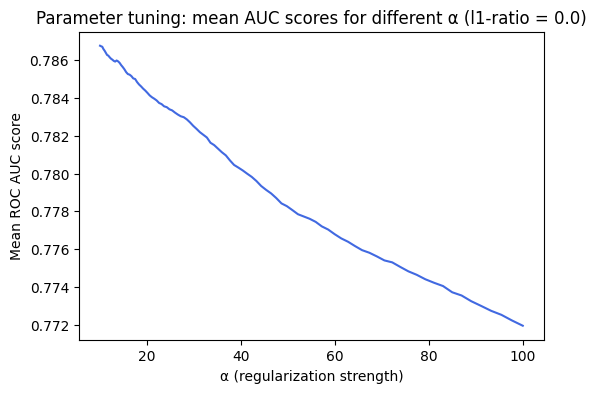

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 55.0 
- Mean ROC AUC score: 0.7867578955620228


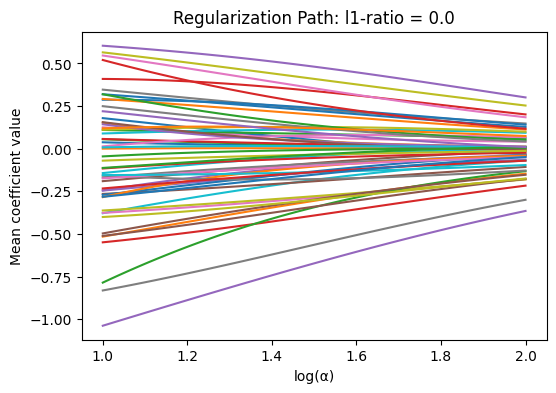

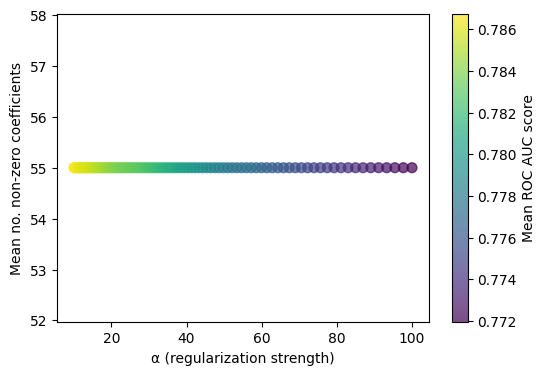

no elbow point


In [61]:
logreg_0, results_0, optimal_C_0 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.0, state = 1, splits = 15, repeats = 10)
dump(logreg_0, 'results/parameter_tuning_models/logreg_0.joblib') 

logreg_0 = load('results/parameter_tuning_models/logreg_0.joblib') 
results_0 = parameter_tuning_results(logreg_0, l1_ratio = 0.0, state = 1, splits = 15, repeats = 10) 
plot_cv_model(results_0, l1_ratio = 0.0, model = logreg_0)

### l1-ratio = 0.1

For l1 ratio = 0.1
the regulation strength with the highest AUC score: 0.1


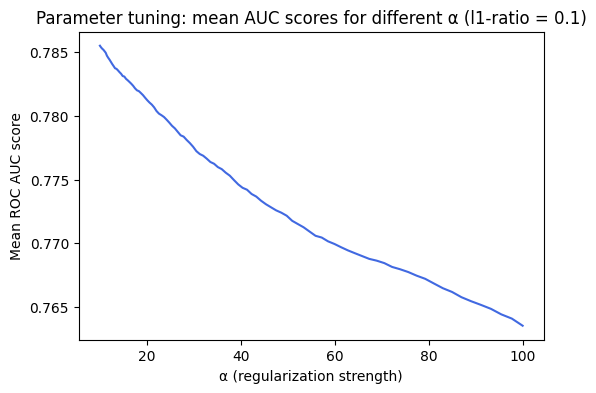

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 49.513333333333335 
- Mean ROC AUC score: 0.7855143366692007


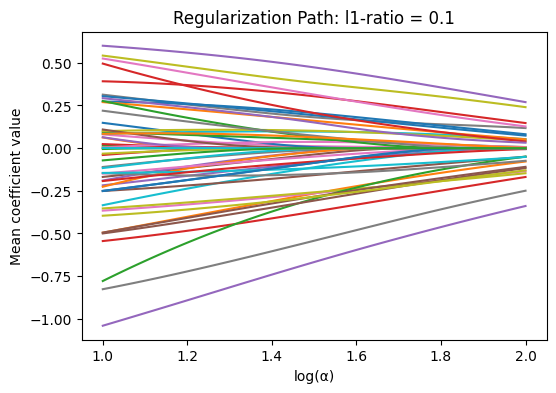

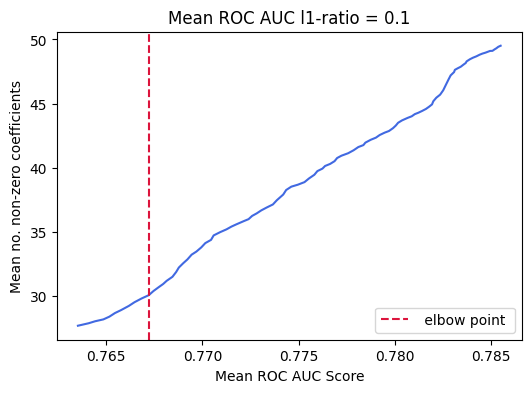

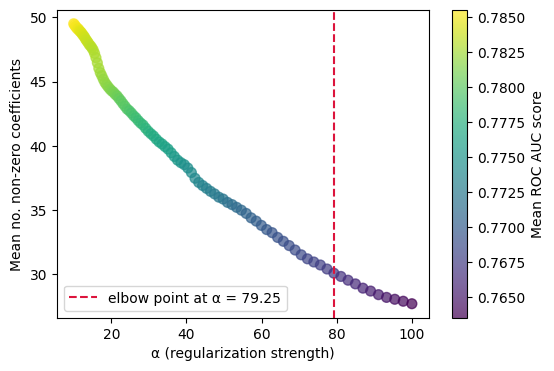

Elbow point: 
- Inverse of regularisation strength C: 0.012618568830660197 
- Regularisation strength α: 79.24828983539177 
- Mean no. non-zero coefficients: 0.7672067222691175 
- Mean ROC AUC score: 30.066666666666666


In [62]:
logreg_0_1, results_0_1, optimal_C_0_1 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.1, state = 1, splits = 15, repeats = 10)
dump(logreg_0_1, 'results/parameter_tuning_models/logreg_0_1.joblib')

logreg_0_1 = load('results/parameter_tuning_models/logreg_0_1.joblib')
results_0_1 = parameter_tuning_results(logreg_0_1, l1_ratio = 0.1, state = 1, splits = 15, repeats = 10)
alpha_elbow_0_1 = plot_cv_model(results_0_1, l1_ratio = 0.1, model = logreg_0_1)

### l1-ratio = 0.2

For l1 ratio = 0.2
the regulation strength with the highest AUC score: 0.1


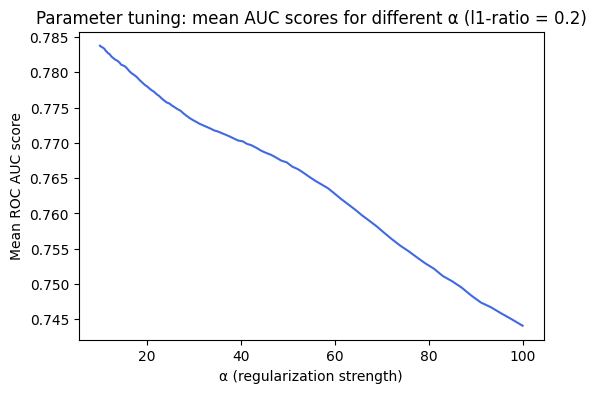

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 43.946666666666665 
- Mean ROC AUC score: 0.7837768440709617


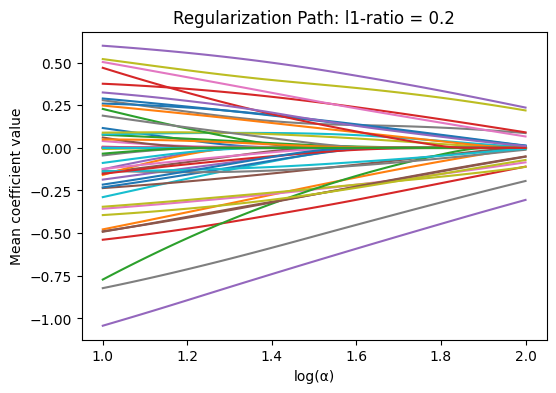

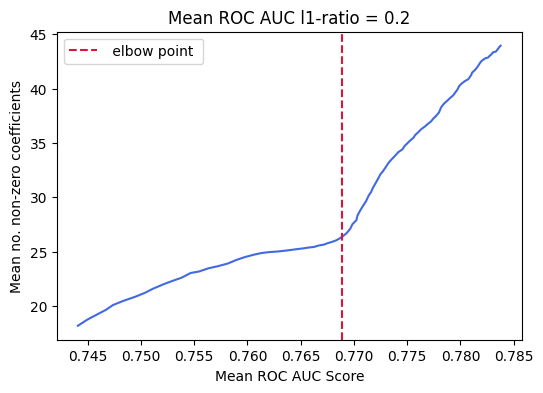

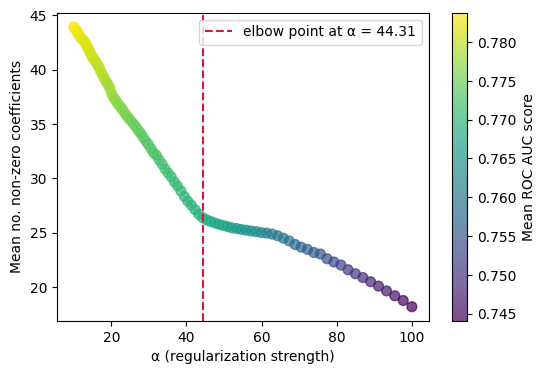

Elbow point: 
- Inverse of regularisation strength C: 0.02257019719633919 
- Regularisation strength α: 44.30621457583882 
- Mean no. non-zero coefficients: 0.7689062506561842 
- Mean ROC AUC score: 26.38


In [63]:
logreg_0_2, results_0_2, optimal_C_0_2 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.2, state = 1, splits = 15, repeats = 10)
dump(logreg_0_2, 'results/parameter_tuning_models/logreg_0_2.joblib') 

logreg_0_2 = load('results/parameter_tuning_models/logreg_0_2.joblib') 
results_0_2 = parameter_tuning_results(logreg_0_2, l1_ratio = 0.2, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_2 = plot_cv_model(results_0_2, l1_ratio = 0.2, model = logreg_0_2)

### l1-ratio = 0.3

For l1 ratio = 0.3
the regulation strength with the highest AUC score: 0.1


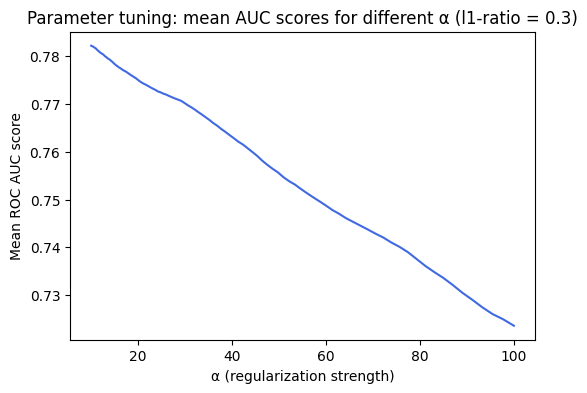

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 40.79333333333334 
- Mean ROC AUC score: 0.7821797784581097


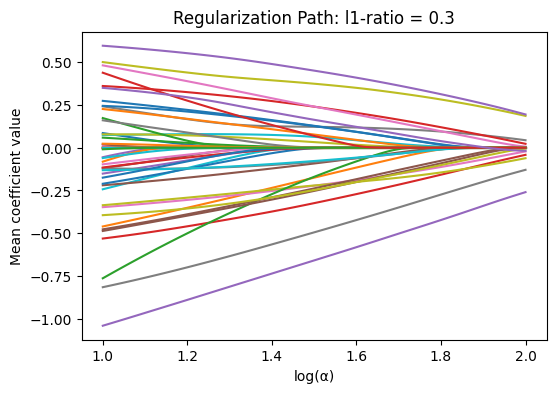

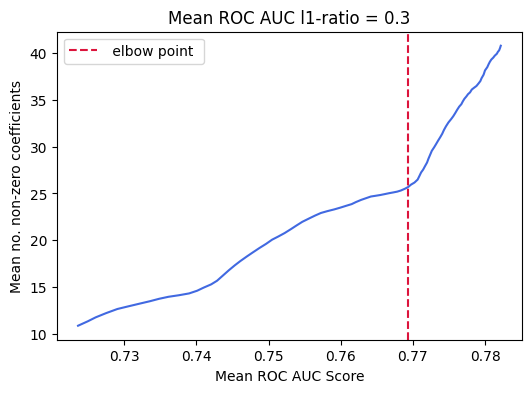

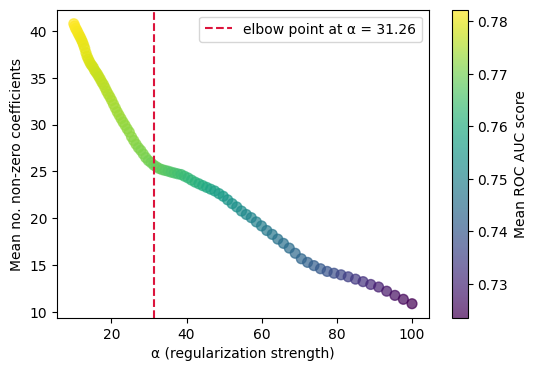

Elbow point: 
- Inverse of regularisation strength C: 0.031992671377973826 
- Regularisation strength α: 31.257158496882372 
- Mean no. non-zero coefficients: 0.7693318781785579 
- Mean ROC AUC score: 25.68


In [64]:
logreg_0_3, results_0_3, optimal_C_0_3 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.3, state = 1, splits = 15, repeats = 10)
dump(logreg_0_3, 'results/parameter_tuning_models/logreg_0_3.joblib')

logreg_0_3 = load('results/parameter_tuning_models/logreg_0_3.joblib') 
results_0_3 = parameter_tuning_results(logreg_0_3, l1_ratio = 0.3, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_3 = plot_cv_model(results_0_3, l1_ratio = 0.3, model = logreg_0_3)

### l1-ratio = 0.4

For l1 ratio = 0.4
the regulation strength with the highest AUC score: 0.1


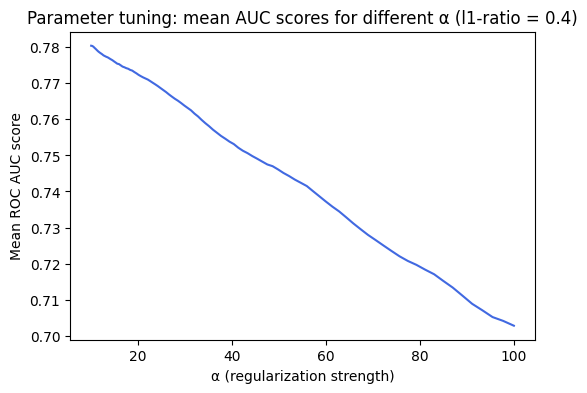

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 37.586666666666666 
- Mean ROC AUC score: 0.7803931997586638


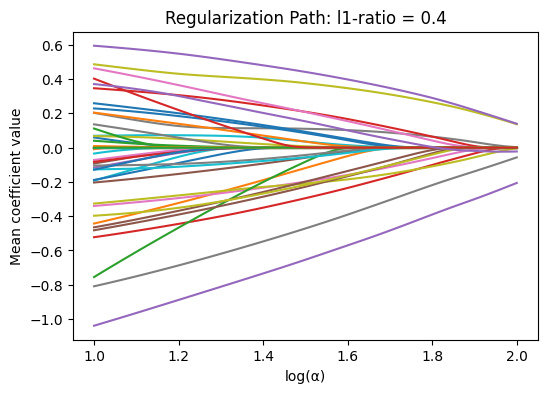

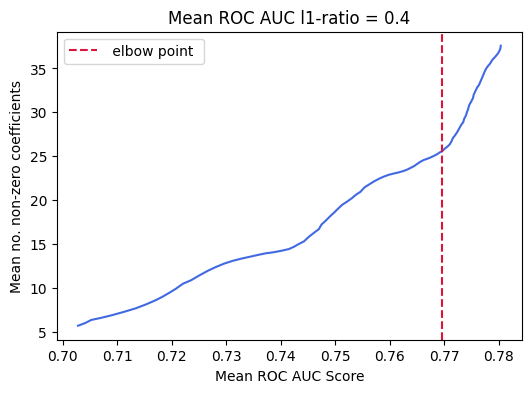

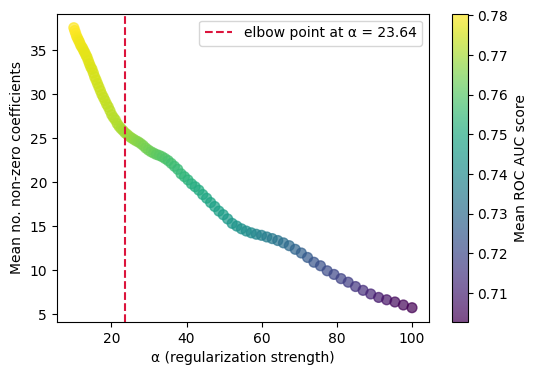

Elbow point: 
- Inverse of regularisation strength C: 0.04229242874389499 
- Regularisation strength α: 23.644894126454073 
- Mean no. non-zero coefficients: 0.7696868022571345 
- Mean ROC AUC score: 25.606666666666666


In [65]:
logreg_0_4, results_0_4, optimal_C_0_4 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.4, 
                                                                                    state = 1, splits = 15, repeats = 10)
dump(logreg_0_4, 'results/parameter_tuning_models/logreg_0_4.joblib')

logreg_0_4 = load('results/parameter_tuning_models/logreg_0_4.joblib') 
results_0_4 = parameter_tuning_results(logreg_0_4, l1_ratio = 0.4, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_4 = plot_cv_model(results_0_4, l1_ratio = 0.4, model = logreg_0_4)

### l1-ratio = 0.5

For l1 ratio = 0.5
the regulation strength with the highest AUC score: 0.1


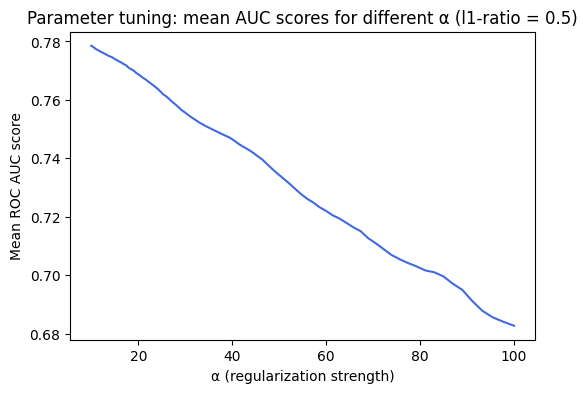

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 35.06 
- Mean ROC AUC score: 0.7785463010791526


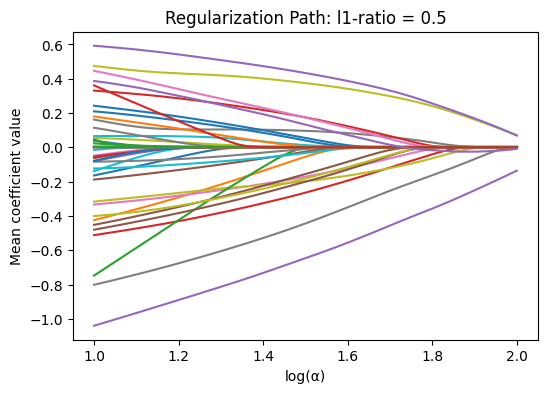

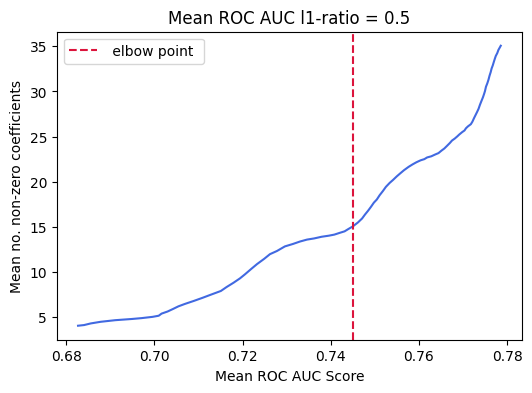

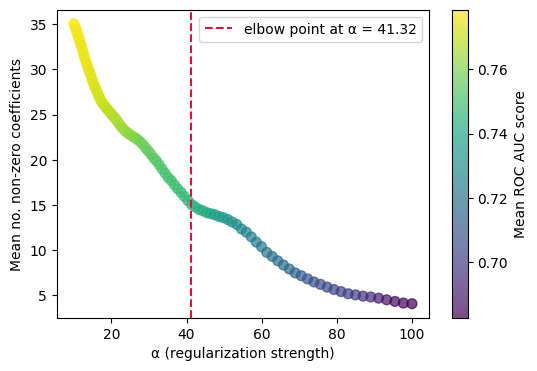

Elbow point: 
- Inverse of regularisation strength C: 0.024201282647943807 
- Regularisation strength α: 41.32012400115339 
- Mean no. non-zero coefficients: 0.7449868133160308 
- Mean ROC AUC score: 15.053333333333333


In [66]:
logreg_0_5, results_0_5, optimal_C_0_5 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.5, state = 1, splits = 15, repeats = 10)
dump(logreg_0_5, 'results/parameter_tuning_models/logreg_0_5.joblib')

logreg_0_5 = load('results/parameter_tuning_models/logreg_0_5.joblib') 
results_0_5 = parameter_tuning_results(logreg_0_5, l1_ratio = 0.5, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_5 = plot_cv_model(results_0_5, l1_ratio = 0.5, model = logreg_0_5)

### l1-ratio = 0.6

For l1 ratio = 0.6
the regulation strength with the highest AUC score: 0.1


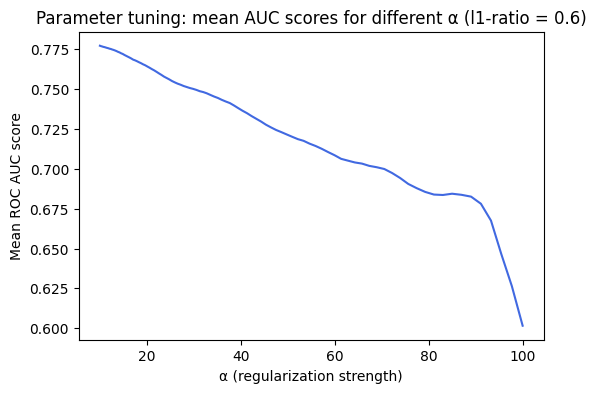

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 32.54 
- Mean ROC AUC score: 0.7772032366169855


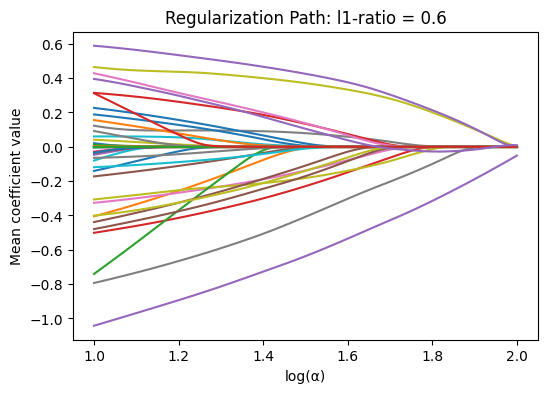

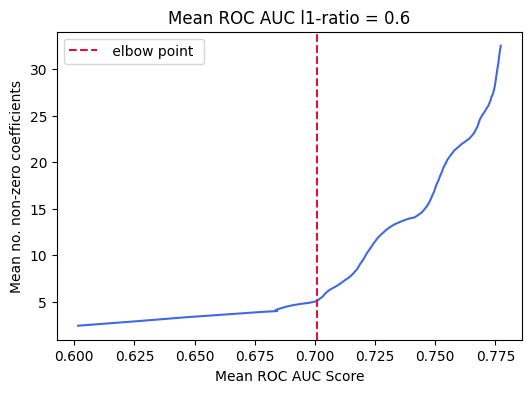

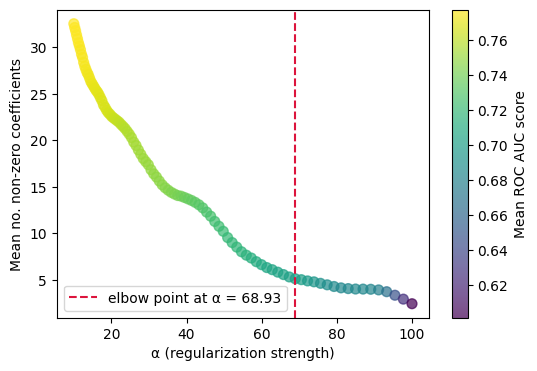

Elbow point: 
- Inverse of regularisation strength C: 0.014508287784959394 
- Regularisation strength α: 68.92612104349699 
- Mean no. non-zero coefficients: 0.7009853686602079 
- Mean ROC AUC score: 5.12


In [67]:
logreg_0_6, results_0_6, optimal_C_0_6 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.6, 
                                                                                    state = 1, splits = 15, repeats = 10)
dump(logreg_0_6, 'results/parameter_tuning_models/logreg_0_6.joblib') 

logreg_0_6 = load('results/parameter_tuning_models/logreg_0_6.joblib') 
results_0_6 = parameter_tuning_results(logreg_0_6, l1_ratio = 0.6, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_6 = plot_cv_model(results_0_6, l1_ratio = 0.6, model = logreg_0_6)

### l1-ratio = 0.7

For l1 ratio = 0.7
the regulation strength with the highest AUC score: 0.1


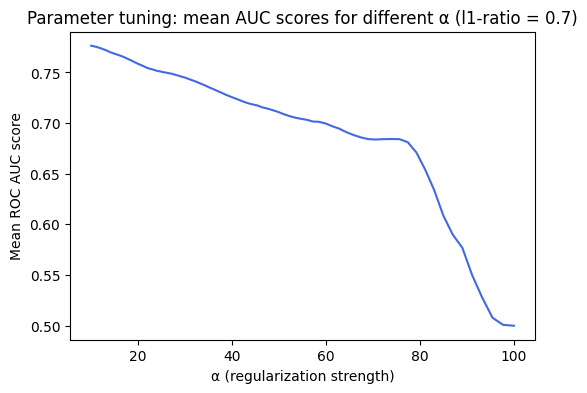

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 29.673333333333332 
- Mean ROC AUC score: 0.7764376180257202


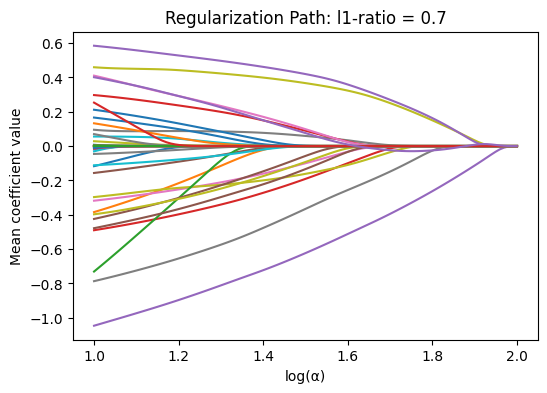

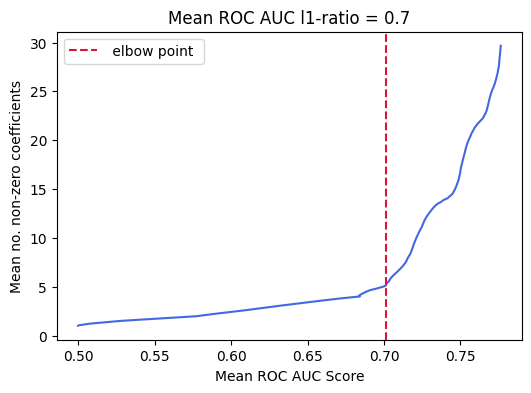

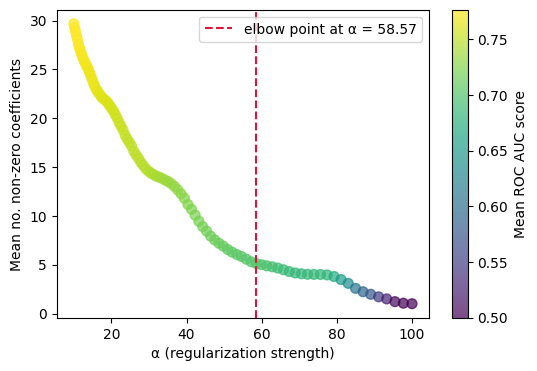

Elbow point: 
- Inverse of regularisation strength C: 0.017073526474706904 
- Regularisation strength α: 58.570208180566674 
- Mean no. non-zero coefficients: 0.7012297772682288 
- Mean ROC AUC score: 5.113333333333333


In [68]:
logreg_0_7, results_0_7, optimal_C_0_7 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.7, 
                                                                                    state = 1, splits = 15, repeats = 10)
dump(logreg_0_7, 'results/parameter_tuning_models/logreg_0_7.joblib')

logreg_0_7 = load('results/parameter_tuning_models/logreg_0_7.joblib') 
results_0_7 = parameter_tuning_results(logreg_0_7, l1_ratio = 0.7, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_7 = plot_cv_model(results_0_7, l1_ratio = 0.7, model = logreg_0_7)

### l1-ratio = 0.8

For l1 ratio = 0.8
the regulation strength with the highest AUC score: 0.1


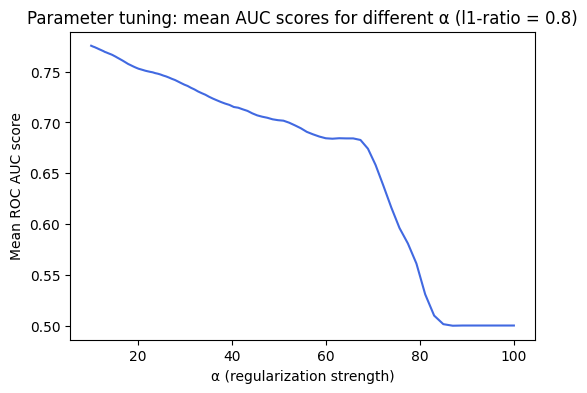

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 27.06 
- Mean ROC AUC score: 0.7755715314611603


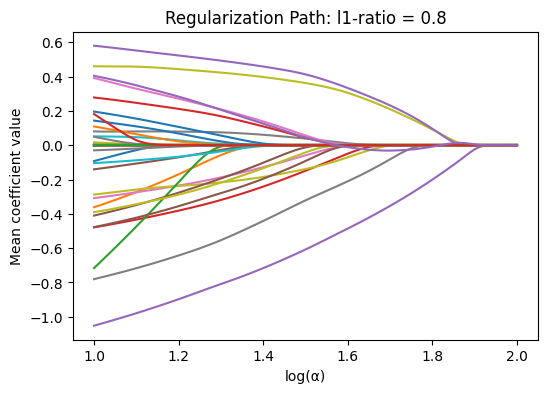

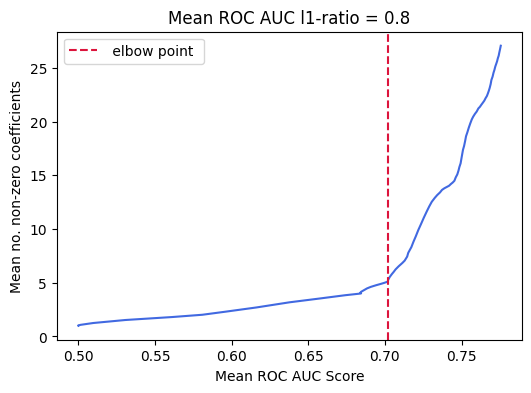

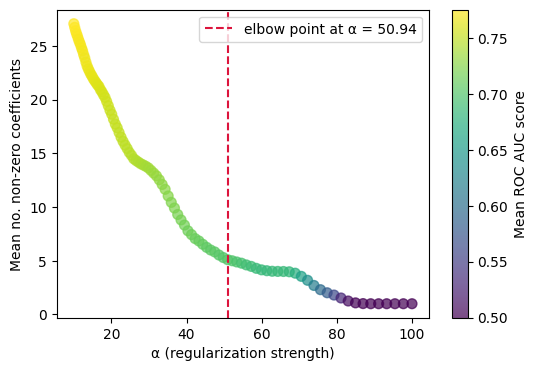

Elbow point: 
- Inverse of regularisation strength C: 0.019630406500402705 
- Regularisation strength α: 50.9413801481638 
- Mean no. non-zero coefficients: 0.7017446563832932 
- Mean ROC AUC score: 5.1


In [69]:
logreg_0_8, results_0_8, optimal_C_0_8 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.8, 
                                                                                    state = 1, splits = 15, repeats = 10)
dump(logreg_0_8, 'results/parameter_tuning_models/logreg_0_8.joblib')

logreg_0_8 = load('results/parameter_tuning_models/logreg_0_8.joblib') 
results_0_8 = parameter_tuning_results(logreg_0_8, l1_ratio = 0.8, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_8 = plot_cv_model(results_0_8, l1_ratio = 0.8, model = logreg_0_8)

### l1-ratio = 0.9

For l1 ratio = 0.9
the regulation strength with the highest AUC score: 0.1


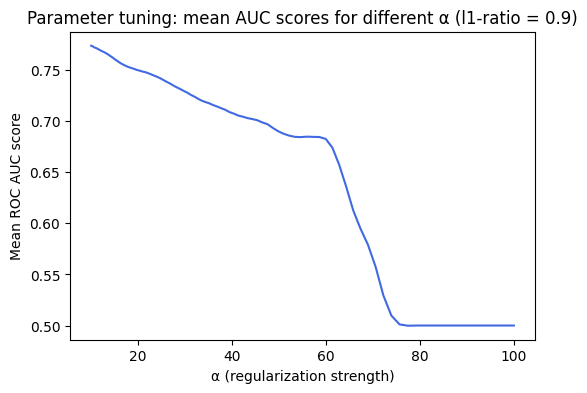

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 25.393333333333334 
- Mean ROC AUC score: 0.7736551962114177


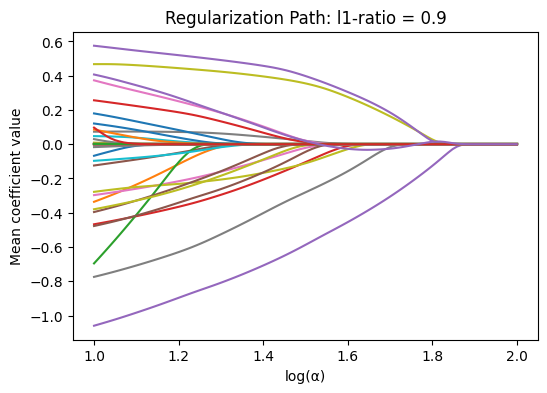

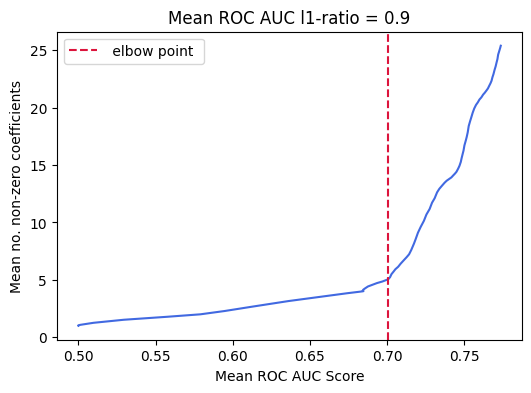

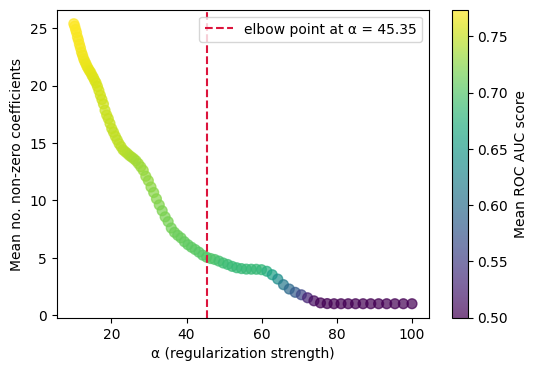

Elbow point: 
- Inverse of regularisation strength C: 0.022051307399030457 
- Regularisation strength α: 45.34878508128582 
- Mean no. non-zero coefficients: 0.7008186697967543 
- Mean ROC AUC score: 5.053333333333334


In [70]:
logreg_0_9, results_0_9, optimal_C_0_9 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 0.9, 
                                                                                    state = 1, splits = 15, repeats = 10)
dump(logreg_0_9, 'results/parameter_tuning_models/logreg_0_9.joblib')

logreg_0_9 = load('results/parameter_tuning_models/logreg_0_9.joblib') 
results_0_9 = parameter_tuning_results(logreg_0_9, l1_ratio = 0.9, state = 1, splits = 15, repeats = 10) 
alpha_elbow_0_9 = plot_cv_model(results_0_9, l1_ratio = 0.9, model = logreg_0_9)

### l1-ratio = 1.0

For l1 ratio = 1.0
the regulation strength with the highest AUC score: 0.1


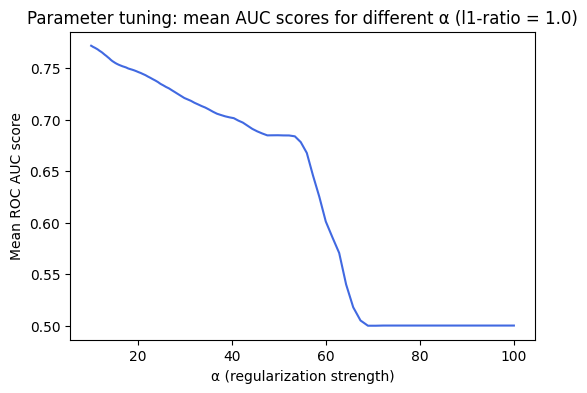

Best AUC: 
- Inverse of regularisation strength C: 0.1 
- Regularisation strength α: 10.0 
- Mean no. non-zero coefficients: 23.713333333333335 
- Mean ROC AUC score: 0.7717777665788953


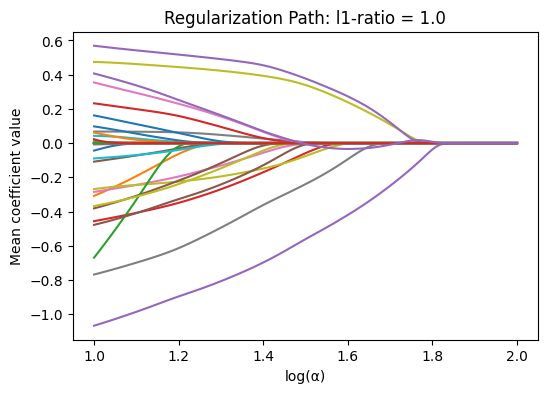

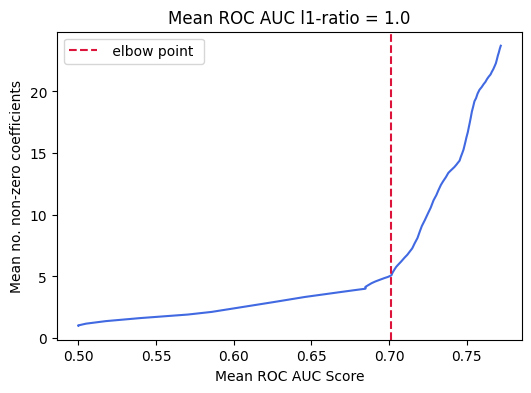

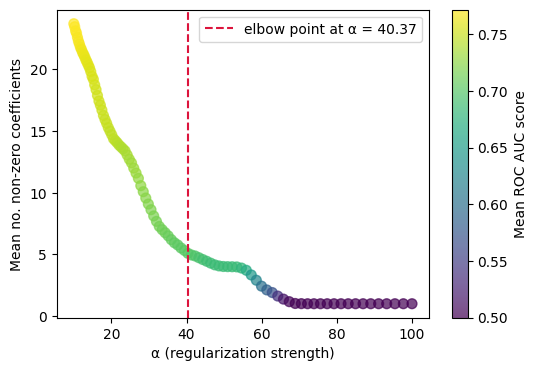

Elbow point: 
- Inverse of regularisation strength C: 0.024770763559917114 
- Regularisation strength α: 40.37017258596554 
- Mean no. non-zero coefficients: 0.7014116786144744 
- Mean ROC AUC score: 5.086666666666667


In [71]:
logreg_1_0, results_1_0, optimal_C_1_0 = parameter_tuning_ROC_AUC(X, y, l1_ratio = 1.0, 
                                                                                    state = 1, splits = 15, repeats = 10)
dump(logreg_1_0, 'results/parameter_tuning_models/logreg_1_0.joblib')

logreg_1_0 = load('results/parameter_tuning_models/logreg_1_0.joblib') 
results_1_0 = parameter_tuning_results(logreg_1_0, l1_ratio = 1.0, state = 1, splits = 15, repeats = 10) 
alpha_elbow_1_0 = plot_cv_model(results_1_0, l1_ratio = 1.0, model = logreg_1_0)

## Model selection

for each l1_ratio a model is fitted with the regularisation strength from elbow point 

### models

In [74]:
rng = np.random.RandomState(1)

# models one for each l1-ratio fitted with regularisation strength from elbow point 
model_0_1 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_1,
            l1_ratio = 0.1,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver ='saga')
      
model_0_1.fit(X, y)

dump(model_0_1, 'results/parameter_tuning_models/logreg_0_1_elbow.joblib') 

model_0_2 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_2,
            l1_ratio = 0.2,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_2.fit(X, y)
dump(model_0_2, 'results/parameter_tuning_models/logreg_0_2_elbow.joblib')

model_0_3 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_3,
            l1_ratio = 0.3,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_3.fit(X, y)
dump(model_0_3, 'results/parameter_tuning_models/logreg_0_3_elbow.joblib')

model_0_4 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_4,
            l1_ratio = 0.4,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_4.fit(X, y)
dump(model_0_4, 'results/parameter_tuning_models/logreg_0_4_elbow.joblib')

model_0_5 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_5,
            l1_ratio = 0.5,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_5.fit(X, y)
dump(model_0_5, 'results/parameter_tuning_models/logreg_0_5_elbow.joblib')

model_0_6 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_6,
            l1_ratio = 0.6,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_6.fit(X, y)
dump(model_0_6, 'results/parameter_tuning_models/logreg_0_6_elbow.joblib')

model_0_7 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_7,
            l1_ratio = 0.7,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_7.fit(X, y)
dump(model_0_7, 'results/parameter_tuning_models/logreg_0_7_elbow.joblib')

model_0_8 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_8,
            l1_ratio = 0.8,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_8.fit(X, y)
dump(model_0_8, 'results/parameter_tuning_models/logreg_0_8_elbow.joblib')

model_0_9 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_0_9,
            l1_ratio = 0.9,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_0_9.fit(X, y)
dump(model_0_9, 'results/parameter_tuning_models/logreg_0_9_elbow.joblib')

model_1_0 = LogisticRegression(
            penalty= 'elasticnet',
            C = 1 / alpha_elbow_1_0,
            l1_ratio = 1.0,
            max_iter = 1000,
            class_weight = "balanced",
            random_state = rng, 
            solver='saga')
      
model_1_0.fit(X, y)
dump(model_1_0, 'results/parameter_tuning_models/logreg_1_0_elbow.joblib')

['results/parameter_tuning_models/logreg_1_0_elbow.joblib']

In [ ]:
# models one for each l1-ratio fitted with regularisation strength from elbow point
model_0_1 = load('parameter_tuning_models/logreg_0_1_elbow_new.joblib') 
model_0_2 = load('parameter_tuning_models/logreg_0_2_elbow_new.joblib') 
model_0_3 = load('parameter_tuning_models/logreg_0_3_elbow_new.joblib') 
model_0_4 = load('parameter_tuning_models/logreg_0_4_elbow_new.joblib') 
model_0_5 = load('parameter_tuning_models/logreg_0_5_elbow_new.joblib') 
model_0_6 = load('parameter_tuning_models/logreg_0_6_elbow_new.joblib') 
model_0_7 = load('parameter_tuning_models/logreg_0_7_elbow_new.joblib') 
model_0_8 = load('parameter_tuning_models/logreg_0_8_elbow_new.joblib') 
model_0_9 = load('parameter_tuning_models/logreg_0_9_elbow_new.joblib') 
model_1_0 = load('parameter_tuning_models/logreg_1_0_elbow_new.joblib') 

### selection

In [75]:
def calculate_aic(y_true, y_pred_proba, num_params):
    # log_loss: negative log-likelihood of a logistic model (- log_loss: log-likelihood) ln(L)
    # normalize = False: sum of the per-sample losses
    log_like = - log_loss(y_true, y_pred_proba, normalize = False)
    aic = 2 * num_params - 2 * log_like
    return aic

def calculate_bic(y_true, y_pred_proba, num_params):
    log_like = - log_loss(y_true, y_pred_proba, normalize = False)
    n = len(y_true) # no. observations
    bic = - 2 * log_like + np.log(n) * num_params 
    return bic


def model_ICs(model, l1, optimal_C, modus):
    y_pred_proba = model.predict_proba(X)[:, 1]
    num_params = len(model.coef_[0]) + 1 # + intercept 
    aic = calculate_aic(y, y_pred_proba, num_params)
    bic = calculate_bic(y, y_pred_proba, num_params)
    
    c = model.coef_.ravel()
    non_zero_index = np.nonzero(c)[0]
    non_zero_coefficients = len(non_zero_index)
    
    auc = roc_auc_score(y, y_pred_proba)
    
    results_IC = pd.DataFrame({
        'l1-ratio': [l1],
        'modus': [modus],
        'inverse regularisation strength C': [optimal_C],
        'regularisation strength alpha': [1/optimal_C],
        'ROC_AUC': [auc],
        'non_zero_coefficients': [non_zero_coefficients],
        'AIC': [aic],
        'BIC': [bic]
    })
      
    return results_IC

In [77]:
# fitted models for each l1-ratio with regularisation strength from elbow point detection
results_best_elbow_0_1 = model_ICs(model_0_1, l1 = 0.1, optimal_C = 1 / alpha_elbow_0_1, modus = "elbow point")
results_best_elbow_0_2 = model_ICs(model_0_2, l1 = 0.2, optimal_C = 1 / alpha_elbow_0_2, modus = "elbow point")
results_best_elbow_0_3 = model_ICs(model_0_3, l1 = 0.3, optimal_C = 1 / alpha_elbow_0_3, modus = "elbow point")
results_best_elbow_0_4 = model_ICs(model_0_4, l1 = 0.4, optimal_C = 1 / alpha_elbow_0_4, modus = "elbow point")
results_best_elbow_0_5 = model_ICs(model_0_5, l1 = 0.5, optimal_C = 1 / alpha_elbow_0_5, modus = "elbow point")
results_best_elbow_0_6 = model_ICs(model_0_6, l1 = 0.6, optimal_C = 1 / alpha_elbow_0_6, modus = "elbow point")
results_best_elbow_0_7 = model_ICs(model_0_7, l1 = 0.7, optimal_C = 1 / alpha_elbow_0_7, modus = "elbow point")
results_best_elbow_0_8 = model_ICs(model_0_8, l1 = 0.8, optimal_C = 1 / alpha_elbow_0_8, modus = "elbow point")
results_best_elbow_0_9 = model_ICs(model_0_9, l1 = 0.9, optimal_C = 1 / alpha_elbow_0_9, modus = "elbow point")
results_best_elbow_1_0 = model_ICs(model_1_0, l1 = 1.0, optimal_C = 1 / alpha_elbow_1_0, modus = "elbow point")

results_model_selection_best_elbow = pd.concat([results_best_elbow_0_1, results_best_elbow_0_2, 
                                                results_best_elbow_0_3, results_best_elbow_0_4, results_best_elbow_0_5, results_best_elbow_0_6, results_best_elbow_0_7,
                                                results_best_elbow_0_8, results_best_elbow_0_9, results_best_elbow_1_0], axis=0, ignore_index=True)  

results_model_selection_best_elbow_rounded = results_model_selection_best_elbow.round(2)
results_model_selection_best_elbow_rounded               

,l1-ratio,modus,inverse regularisation strength C,regularisation strength alpha,ROC_AUC,non_zero_coefficients,AIC,BIC
0,0.1,elbow point,0.01,79.25,0.79,30,1878.87,2169.53
1,0.2,elbow point,0.02,44.31,0.79,25,1833.84,2124.50
2,0.3,elbow point,0.03,31.26,0.79,24,1811.00,2101.66
3,0.4,elbow point,0.04,23.64,0.79,25,1793.19,2083.86
4,0.5,elbow point,0.02,41.32,0.77,14,1905.98,2196.65
5,0.6,elbow point,0.01,68.93,0.71,4,2042.56,2333.23
6,0.7,elbow point,0.02,58.57,0.71,4,2032.91,2323.58
7,0.8,elbow point,0.02,50.94,0.71,4,2024.68,2315.34
8,0.9,elbow point,0.02,45.35,0.71,4,2018.65,2309.32
9,1.0,elbow point,0.02,40.37,0.71,4,2011.03,2301.69


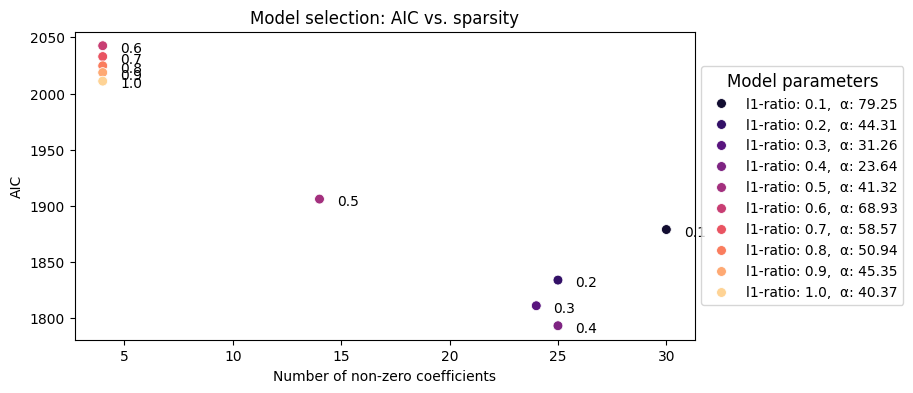

In [78]:
# scatter plot: AIC vs. sparsity (number of non-zero coefficients)
# we want: low AIC and low no. of coefficients

# trained models with regularisation strength from elbow point
plt.figure(figsize=(8, 4))
scatter_elbow = sns.scatterplot(data = results_model_selection_best_elbow, x ='non_zero_coefficients', y ='AIC', hue ='l1-ratio', 
                          palette = sns.color_palette("magma", 10), s = 50)
for i in range(results_model_selection_best_elbow.shape[0]): # add labels to scatter points 
    plt.text(
        results_model_selection_best_elbow['non_zero_coefficients'].iloc[i] + 0.8, 
        results_model_selection_best_elbow['AIC'].iloc[i] - 6,
        f'{results_model_selection_best_elbow["l1-ratio"].iloc[i]:.1f}',  
        fontsize = 10,
        ha = 'left')
handles, labels = scatter_elbow.get_legend_handles_labels() # add alpha to legend
custom_labels = [
    f'l1-ratio: {results_model_selection_best_elbow["l1-ratio"].iloc[i]:.1f}, '
    f' α: {results_model_selection_best_elbow["regularisation strength alpha"].iloc[i]:.2f}'
    for i in range(len(labels) )
]
plt.legend(handles = handles[:], labels = custom_labels, title = 'Model parameters', title_fontsize='12', loc='center left',  bbox_to_anchor=(1, 0.5))
plt.xlabel('Number of non-zero coefficients')
plt.ylabel('AIC')
plt.title('Model selection: AIC vs. sparsity')
plt.show()

## Multivariable analysis

### Multivariable regression model
selected model from model selection

In [81]:
final_model = load('results/parameter_tuning_models/logreg_0_4_elbow.joblib')  # based on model selection 
final_model.fit(X, y)

# final coefficients
final_coefficients = final_model.coef_
final_non_zero_coefficients = final_coefficients[np.nonzero(final_coefficients)]
final_non_zero_feature_names = feature_names[np.nonzero(final_coefficients)[1]]
final_non_zero_coefficients_df = pd.DataFrame({'Feature': final_non_zero_feature_names,
                                               'Coefficient': final_non_zero_coefficients})

final_coefficients_df = pd.DataFrame({'Feature': feature_names,
                                      'Coefficient': final_coefficients[0]})
# final_coefficients_df.to_csv('results/final_model_regression_coefficients_new.csv', index = False)

# optimal classification threshold 
y_proba = final_model.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_proba)
optimal_threshold_index  = np.argmax(tpr  - fpr)
optimal_threshold  = thresholds[optimal_threshold_index]
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

#### non-zero regression coefficients (scatterplot)

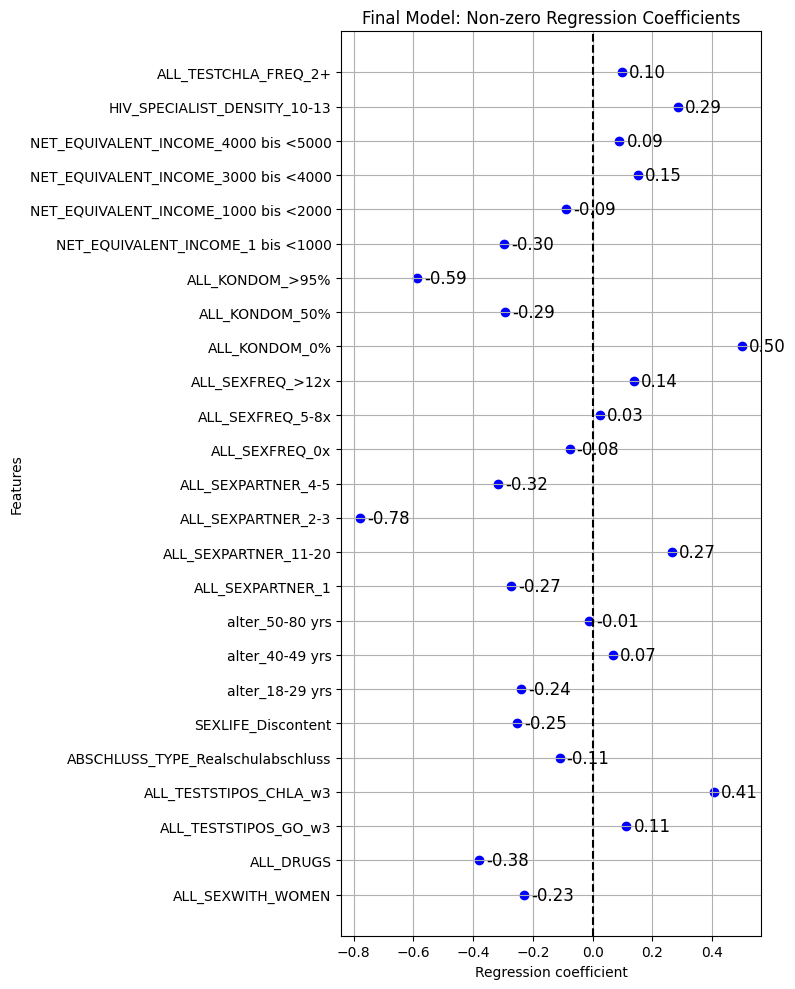

In [83]:
# scatterplot: non-zero coefficients
plt.figure(figsize=(8, 10))
plt.scatter(final_non_zero_coefficients_df['Coefficient'], final_non_zero_coefficients_df['Feature'], color='b')
plt.xlabel('Regression coefficient')
plt.axvline(0, color='black', linestyle='--')
plt.ylabel('Features')
plt.title('Final Model: Non-zero Regression Coefficients')

for i, row in final_non_zero_coefficients_df.iterrows():
    plt.text(
        x=row['Coefficient'] + 0.03 * max(abs(final_non_zero_coefficients_df['Coefficient'])), 
        y=row['Feature'],
        s=f"{row['Coefficient']:.2f}",
        va='center',
        fontsize=12,
        color='black'
    )
plt.grid()
plt.tight_layout()
plt.show()

In [84]:
# non-zero coefficients
round(final_non_zero_coefficients_df,2)

,Feature,Coefficient
0,ALL_SEXWITH_WOMEN,-0.23
1,ALL_DRUGS,-0.38
2,ALL_TESTSTIPOS_GO_w3,0.11
3,ALL_TESTSTIPOS_CHLA_w3,0.41
4,ABSCHLUSS_TYPE_Realschulabschluss,-0.11
5,SEXLIFE_Discontent,-0.25
6,alter_18-29 yrs,-0.24
7,alter_40-49 yrs,0.07
8,alter_50-80 yrs,-0.01
9,ALL_SEXPARTNER_1,-0.27


#### optimal classification threshold

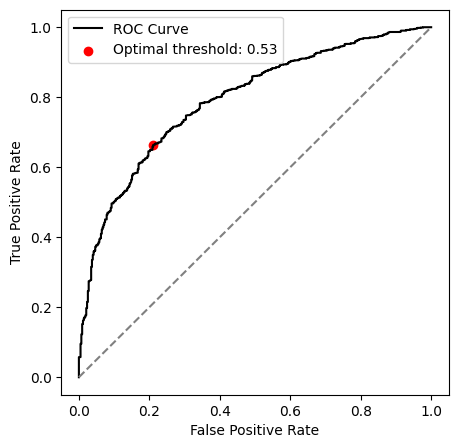

In [ ]:
# ROC curve with optimal classification threshold
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC Curve', color = 'black')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], 
            marker='o', color='red', label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

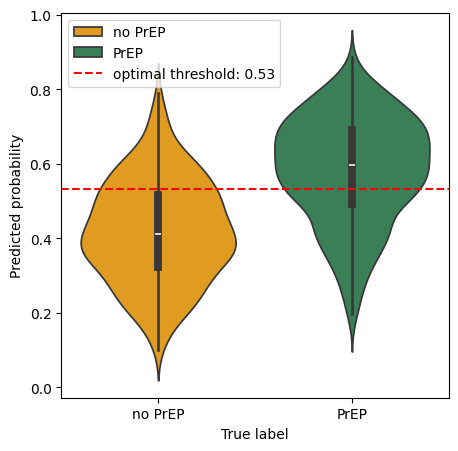

In [87]:
adjusted_classification_threshold = pd.DataFrame({
    'True Label': y,
    'Predicted Probability': y_proba,
    'Group': np.where(y == 1, 'PrEP', 'no PrEP')})

colors_group = {'PrEP': 'seagreen', 'no PrEP': 'orange'}

# violin plot: predicted probabilities with optimal classification threshold
plt.figure(figsize=(5, 5))
sns.violinplot(x = 'True Label', y ='Predicted Probability', data = adjusted_classification_threshold, palette = colors_group, hue = 'Group')
plt.axhline(optimal_threshold, color='red', linestyle='--', label=f'optimal threshold: {optimal_threshold:.2f}')
plt.xlabel('True label')
plt.xticks([0, 1], labels = ['no PrEP', 'PrEP'])
plt.ylabel('Predicted probability')
plt.legend()
plt.show()

#### model validation 

In [94]:
# validate 
final_coefficients = final_model.coef_[0] # all coefficients -> betas 
final_intercept = final_model.intercept_ # intercept -> beta_0
adjusted_threshold = optimal_threshold # classification threshold


# test data: single observation
test_data = X[400]  
log_odds = np.dot(test_data, final_coefficients) + final_intercept # linear combination (X * betas + beta_0)
probabilities = 1 / (1 + np.exp(-log_odds)) # logistic function
predictions = (probabilities >= adjusted_threshold).astype(int) # apply classification threshold

print("Probability:", probabilities[0])
print("Predicted Label:", predictions[0])
print('True label:', y[2])

# for all observations
test_data = X 
log_odds = np.dot(test_data, final_coefficients) + final_intercept # linear combination (X * betas + beta_0)
probabilities = 1 / (1 + np.exp(-log_odds)) # logistic function
predictions = (probabilities >= adjusted_threshold).astype(int) # apply classification threshold

a = (predictions == y) # compare predictions with true labels
print(np.unique(a, return_counts=True)) # count true and false predictions

Probability: 0.8166061438588836
Predicted Label: 1
True label: 1
(array([False,  True]), array([ 436, 1022]))


### Bootstrapping 
10,000 stratified bootstrapped sampled 

In [97]:
final_model = load('results/parameter_tuning_models/logreg_0_4_elbow.joblib') # load final selected model 
rng = np.random.RandomState(1)
bootstrapped_coefficients = []

for _ in range(10000):
    X_bootstrap, y_bootstrap = resample(X, y, 
                                        random_state = rng, 
                                        stratify = y,
                                        replace = True)
    final_model.fit(X_bootstrap, y_bootstrap)
    bootstrapped_coefficients.append(final_model.coef_[0])
    
bootstrapped_coefficients_df = pd.DataFrame(bootstrapped_coefficients, columns = feature_names) # all bootstrapped regression coefficients
non_zero_bootstrapped_coefficients_df = bootstrapped_coefficients_df.loc[:, (bootstrapped_coefficients_df != 0).any(axis=0)] # all bootstrapped non-zeroregression coefficients


#### non-parametric bootstrap: percentile confidence interval 

In [107]:
CI_lower = np.percentile(np.array(bootstrapped_coefficients_df), 2.5, axis = 0) # lower 95% confidence interval
CI_upper = np.percentile(np.array(bootstrapped_coefficients_df), 97.5, axis = 0) # upper 95% confidence interval

multivariable_coef_results = final_coefficients_df.copy()
multivariable_coef_results['lower 95% CI'] = CI_lower
multivariable_coef_results['upper 95% CI'] = CI_upper 

In [108]:
significant_coefs = (CI_lower > 0) | (CI_upper < 0) # significant coefficients based on confidence intervals (check: is 0 included in the CI)

significant_from_CI_df = pd.DataFrame({
    'Feature': bootstrapped_coefficients_df.columns,
    'Lower 95% CI': CI_lower,
    'Upper 95% CI': CI_upper,
    'Significant': significant_coefs
})

# compare this to significant based on bootstrapped p-value 
significant_from_CI_df.loc[significant_from_CI_df['Significant'] == True]

,Feature,Lower 95% CI,Upper 95% CI,Significant
3,ALL_DRUGS,-0.576914,-0.172110,True
8,ALL_TESTSTIPOS_CHLA_w3,0.204789,0.615902,True
16,SEXLIFE_Discontent,-0.469852,-0.017375,True
18,alter_18-29 yrs,-0.455517,-0.032014,True
23,ALL_SEXPARTNER_11-20,0.037712,0.501950,True
24,ALL_SEXPARTNER_2-3,-0.992521,-0.553844,True
25,ALL_SEXPARTNER_4-5,-0.527659,-0.083653,True
34,ALL_KONDOM_0%,0.286074,0.709690,True
35,ALL_KONDOM_50%,-0.512612,-0.066842,True
37,ALL_KONDOM_>95%,-0.828009,-0.349297,True


#### non-parametric bootstrap: hypothesis test 

H0: β = 0 

H1: β ≠ 0 

In [ ]:
bootstrap_samples = 10000
p_values_features = {}

for feature in bootstrapped_coefficients_df.columns:
    bst_coefs = bootstrapped_coefficients_df[feature] # bootstrapped coefficients for the feature

    greater_than_zero = np.sum(bst_coefs >= 0) / bootstrap_samples # sum of bootstrapped coefficients >= zero / bootstrap samples
    less_than_zero = np.sum(bst_coefs <= 0) / bootstrap_samples # sum of bootstrapped coefficients <= zero / bootstrap samples
    
    p_value = min(greater_than_zero, less_than_zero)
    p_values_features[feature] = p_value


p_values_features_df = pd.DataFrame([p_values_features]).T
p_values_features_df.rename(columns = {0: 'p_values'}, inplace = True)


multivariable_coef_results['p_values'] = p_values_features_df['p_values'].values
multivariable_coef_results.to_csv('results/multivariable_analysis_result.csv', index = True)

p_values_features_df.sort_values(by = 'p_values', ascending = True)

,p_values
ALL_KONDOM_0%,0.0000
ALL_SEXPARTNER_2-3,0.0000
ALL_TESTSTIPOS_CHLA_w3,0.0000
ALL_KONDOM_>95%,0.0000
ALL_DRUGS,0.0001
HIV_SPECIALIST_DENSITY_10-13,0.0036
ALL_SEXPARTNER_4-5,0.0041
ALL_KONDOM_50%,0.0064
ALL_SEXPARTNER_11-20,0.0112
alter_18-29 yrs,0.0129


In [110]:
columns_2_decimal = ['Coefficient', 'lower 95% CI', 'upper 95% CI']
columns_3_decimal = ['p_values']

multivariable_coef_results_rounded = multivariable_coef_results.copy()
multivariable_coef_results_rounded[columns_2_decimal] = multivariable_coef_results_rounded[columns_2_decimal].round(2)
multivariable_coef_results_rounded[columns_3_decimal] = multivariable_coef_results_rounded[columns_3_decimal].round(3)
multivariable_coef_results_rounded

,Feature,Coefficient,lower 95% CI,upper 95% CI,p_values
0,ALL_SEXWITH_MEN,0.00,0.00,0.00,1.000
1,ALL_SEXWITH_WOMEN,-0.23,-0.48,0.00,0.056
2,ALL_SEXWITH_NONBINARY,0.00,0.00,0.00,0.999
3,ALL_DRUGS,-0.38,-0.58,-0.17,0.000
4,ALL_SEXWORK,0.00,-0.20,0.00,0.653
5,ALL_STI_SYMPTOM,0.00,-0.14,0.01,0.726
6,ALL_TESTSTIPOS_SYPH_w3,0.00,-0.03,0.12,0.813
7,ALL_TESTSTIPOS_GO_w3,0.11,0.00,0.32,0.100
8,ALL_TESTSTIPOS_CHLA_w3,0.41,0.20,0.62,0.000
9,ALL_TESTSTIPOS_HCV_w3,0.00,-0.21,0.00,0.680


#### boxplot significant variables 

In [ ]:
# 13 significant features
significant_features_multivariate = multivariable_coef_results.loc[multivariable_coef_results['p_values'] < 0.05]['Feature']
significant_bst_coef = bootstrapped_coefficients_df[significant_features_multivariate]

In [122]:
plot_variables = ['ALL_DRUGS', 'ALL_TESTSTIPOS_CHLA_w3', 'SEXLIFE_Discontent', 'SEXLIFE_Sex doesnt matter right now',
                  'alter_18-29 yrs', 'alter_40-49 yrs', 'alter_50-80 yrs', 'ALL_SEXPARTNER_0', 'ALL_SEXPARTNER_1', 'ALL_SEXPARTNER_11-20',
                  'ALL_SEXPARTNER_2-3', 'ALL_SEXPARTNER_4-5', 'ALL_SEXPARTNER_6-10',
                  'ALL_KONDOM_0%', 'ALL_KONDOM_50%', 'ALL_KONDOM_75%', 'ALL_KONDOM_>95%',
                  'NET_EQUIVALENT_INCOME_1 bis <1000', 'NET_EQUIVALENT_INCOME_1000 bis <2000', 'NET_EQUIVALENT_INCOME_3000 bis <4000',
                  'NET_EQUIVALENT_INCOME_4000 bis <5000', 'NET_EQUIVALENT_INCOME_5000+',
                  'HIV_SPECIALIST_DENSITY_0', 'HIV_SPECIALIST_DENSITY_1-2', 'HIV_SPECIALIST_DENSITY_10-13', 'HIV_SPECIALIST_DENSITY_3-5']

plot_bst_strata = bootstrapped_coefficients_df[plot_variables]

# add reference categories as 0 
plot_bst_strata['30-39 years (R)'] = 0
plot_bst_strata['6-9 (R)'] = 0
plot_bst_strata['2000 - <3000€ (R)'] = 0
plot_bst_strata['Content (R)'] = 0
plot_bst_strata[r'$\geq$ 20 (R)'] = 0
plot_bst_strata['25% (R)'] = 0

plot_bst_strata_renamed = plot_bst_strata.rename(columns = {'alter_18-29 yrs': r'$\mathbf{Age}$ 18-29 years',
                                                            'alter_40-49 yrs': '40-49 years', 'alter_50-80 yrs': '50-80 years',
                                                            'HIV_SPECIALIST_DENSITY_0': r'$\mathbf{HIV-specialists\ density}$ 0', 'HIV_SPECIALIST_DENSITY_1-2':'1-2', 
                                                            'HIV_SPECIALIST_DENSITY_3-5': '3-5', 'HIV_SPECIALIST_DENSITY_10-13': '10-13',
                                                            'NET_EQUIVALENT_INCOME_1 bis <1000': r'$\mathbf{Monthly\ net-equivalent\ income}$ 1 - <1000€',
                                                            'NET_EQUIVALENT_INCOME_1000 bis <2000': '1000 - <2000€',
                                                            'NET_EQUIVALENT_INCOME_3000 bis <4000': '3000 - <4000€',
                                                            'NET_EQUIVALENT_INCOME_4000 bis <5000': '4000 - <5000€', 
                                                            'NET_EQUIVALENT_INCOME_5000+': r'$\geq$ 5000€',
                                                            'SEXLIFE_Discontent': r'$\mathbf{Satisfaction\ with\ sex\ life}$ Discontent',
                                                            'SEXLIFE_Sex doesnt matter right now': "Sex doesn't matter right now",
                                                            'ALL_SEXPARTNER_0': r'$\mathbf{Sex\ partners\ in\ the\ last\ 6\ months}$ 0',
                                                            'ALL_SEXPARTNER_1': '1',
                                                            'ALL_SEXPARTNER_2-3': '2-3',
                                                            'ALL_SEXPARTNER_4-5': '4-5',
                                                            'ALL_SEXPARTNER_6-10': '6-10',
                                                            'ALL_SEXPARTNER_11-20': '11-20',
                                                            'ALL_KONDOM_0%': r'$\mathbf{Condom\ use}$ 0%',
                                                            'ALL_KONDOM_50%': '50%',
                                                            'ALL_KONDOM_75%': '75%',
                                                            'ALL_KONDOM_>95%': '>95%',
                                                            'ALL_DRUGS': r'$\mathbf{Sexualized\ substance\ use\ in\ the\ last\ 6\ months}$',
                                                            'ALL_TESTSTIPOS_CHLA_w3': r'$\mathbf{Chlamydia\ diagnosis\ in\ the\ past}$'})

column_order = [r'$\mathbf{Age}$ 18-29 years', '30-39 years (R)', '40-49 years', '50-80 years', r'$\mathbf{HIV-specialists\ density}$ 0', '1-2', '3-5', '6-9 (R)', '10-13',
                r'$\mathbf{Monthly\ net-equivalent\ income}$ 1 - <1000€', '1000 - <2000€', '2000 - <3000€ (R)', '3000 - <4000€', '4000 - <5000€', r'$\geq$ 5000€',
                r'$\mathbf{Satisfaction\ with\ sex\ life}$ Discontent', 'Content (R)', "Sex doesn't matter right now", 
                r'$\mathbf{Sex\ partners\ in\ the\ last\ 6\ months}$ 0', '1', '2-3', '4-5', '6-10', '11-20', r'$\geq$ 20 (R)', 
                r'$\mathbf{Condom\ use}$ 0%', '25% (R)', '50%', '75%', '>95%',
                r'$\mathbf{Sexualized\ substance\ use\ in\ the\ last\ 6\ months}$', 
                r'$\mathbf{Chlamydia\ diagnosis\ in\ the\ past}$']

# color by significantly associated with PrEP use (green) / non-PrEP use (orange), or not significantly associated (grey)
column_colors = {r'$\mathbf{Age}$ 18-29 years': 'orange', '30-39 years (R)': 'grey', '40-49 years': 'grey', '50-80 years': 'grey',
                r'$\mathbf{HIV-specialists\ density}$ 0': 'grey', '1-2': 'grey', '3-5': 'grey', '6-9 (R)': 'grey', '10-13': 'seagreen',
                r'$\mathbf{Monthly\ net-equivalent\ income}$ 1 - <1000€': 'orange', '1000 - <2000€': 'grey', '2000 - <3000€ (R)': 'grey', '3000 - <4000€': 'grey', 
                '4000 - <5000€': 'grey', r'$\geq$ 5000€': 'grey',
                r'$\mathbf{Satisfaction\ with\ sex\ life}$ Discontent': 'orange', 'Content (R)': 'grey', "Sex doesn't matter right now": 'grey', 
                r'$\mathbf{Sex\ partners\ in\ the\ last\ 6\ months}$ 0': 'grey', '1': 'orange', '2-3': 'orange', '4-5': 'orange', '6-10': 'grey', '11-20': 'seagreen', r'$\geq$ 20 (R)': 'grey', 
                r'$\mathbf{Condom\ use}$ 0%': 'seagreen', '25% (R)': 'grey', '50%': 'orange', '75%': 'grey', '>95%': 'orange',
                r'$\mathbf{Sexualized\ substance\ use\ in\ the\ last\ 6\ months}$': 'orange',
                r'$\mathbf{Chlamydia\ diagnosis\ in\ the\ past}$': 'seagreen'}

color_palette = [column_colors.get(col, 'gray') for col in plot_bst_strata_renamed.columns]

/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/4074325951.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_bst_strata['30-39 years (R)'] = 0
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/4074325951.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_bst_strata['6-9 (R)'] = 0
/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/4074325951.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

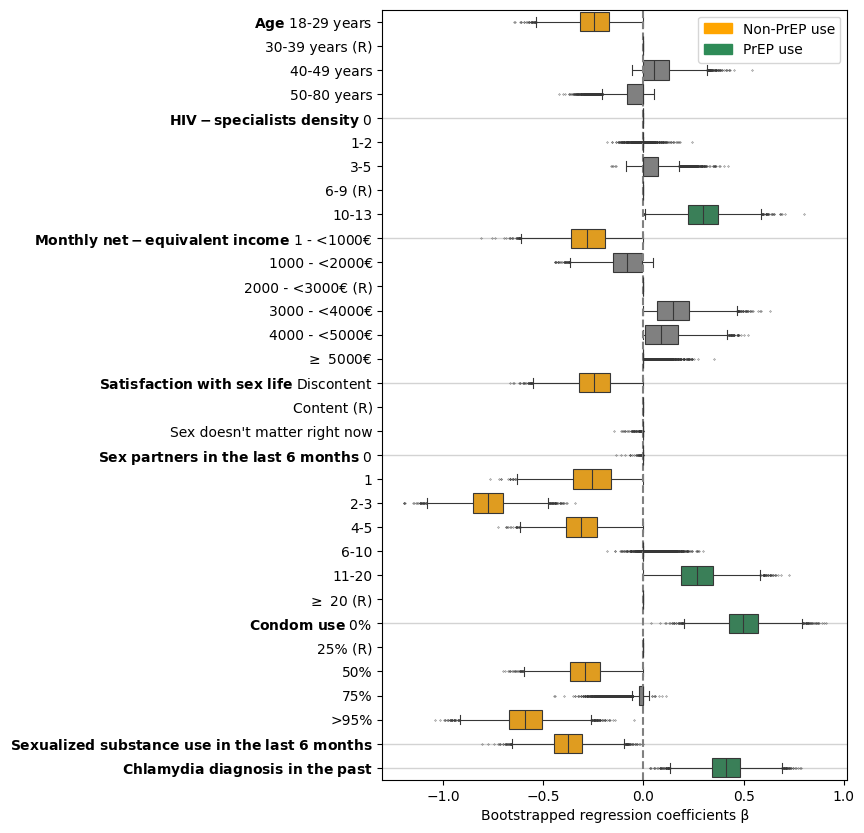

In [119]:
plt.figure(figsize=(6, 10))
sns.boxplot(data = plot_bst_strata_renamed , 
            orient = "h", 
            fliersize = 0.3,
            linewidth = 0.8,
            order = column_order,
            palette= color_palette)
plt.xlabel('Bootstrapped regression coefficients β')
plt.ylabel('')
y_ticks_to_mark= [4, 9, 15, 18, 25, 30, 31]
for y in y_ticks_to_mark:
    plt.axhline(y=y, color='lightgrey', linestyle='-', linewidth=1, zorder=0) # add horizontal lines to mark different strata


plt.axvline(x = 0, color = 'grey', linestyle='--') # add vertical line at 0 to mark no effect 
no_prep = mpatches.Patch(color = 'orange', label = 'Non-PrEP use')
prep = mpatches.Patch(color = 'seagreen', label = 'PrEP use')
plt.legend(handles=[no_prep, prep]) 
plt.savefig('figs/boxplot_significant_variables_and_strata.png', dpi = 600, bbox_inches='tight')  
plt.show()

## Sensitivity analysis

### Multivariable analysis 
check if missing value imputation is correct by encoding missing as a seperate category 

#### Encoding
same as in main analysis with the exception that for the categorical variables the missing values are treated as a seperate category and are encoded as well 

In [ ]:
# concatenate PrEP users and non-PrEP users with a PrEP indication (n = 1,458)
concatenated_population_sensitivity = pd.concat([PrEP_indication, no_PrEP_indication], ignore_index = True) 

# drop unnecessary columns (for multivariable analysis)
concatenated_population_sensitivity.drop(['welle', 'status', 'NO_PREPGRUND_C1_w3', 'NO_PREPGRUND_C4_w3',
                              'NO_PREPGRUND_C6_w3', 'NO_PREPGRUND_C5_w3', 'NO_PREPGRUND_C8_w3',
                              'NO_PREPGRUND_C9_w3', 'NO_PREPGRUND_C7_w3', 'NO_PREPGRUND_C3_w3',
                              'HIV_SPECIALIST_DENSITY_grouped'], axis = 1, inplace = True) 

print(f'Number of Variables (including the target variable): {len(concatenated_population_sensitivity .columns)}')


# already binary variables --> transform into 0/1 
concatenated_population_sensitivity.replace(to_replace = {'ja': 1, 'Ja': 1, 'nein': 0, 'Nein': 0}, inplace = True) 

# already binary w/o missing values --> no further encoding 
binary_columns = ['ALL_SEXWITH_MEN','ALL_SEXWITH_WOMEN','ALL_SEXWITH_NONBINARY', 
                  'ALL_TESTSTIPOS_SYPH_w3', 'ALL_TESTSTIPOS_GO_w3','ALL_TESTSTIPOS_CHLA_w3','ALL_TESTSTIPOS_KEINE_w3',
                  'ALL_TESTSTIPOS_HCV_w3', 'landbin']


# categorical variables (including binary variables with NaNs) 
categorical_columns_sensitivity = ['ABSCHLUSS_TYPE', 'SEXLIFE', 'alter', 'ALL_SEXPARTNER', 'ALL_SEXFREQ', 
                                   'ALL_DRUGS_INJECT', 'ALL_KONDOM',
                                   'NET_EQUIVALENT_INCOME', 'URBAN_RURAL_AREA', 'HIV_SPECIALIST_DENSITY', 
                                   'ALL_TESTSYPH_FREQ', 'ALL_TESTGO_FREQ', 'ALL_TESTCHLA_FREQ',
                                   'ALL_TESTHCV_FREQ', 'ALL_STI_SYMPTOM', 'ALL_DRUGS', 'ALL_SEXWORK']

# encode categorical variables as dummy variables (keep NaNs as a seperate category)
encoded_population_sensitivity = pd.get_dummies(data = concatenated_population_sensitivity, 
                         columns = categorical_columns_sensitivity, 
                         dtype = int, dummy_na = True, 
                         drop_first = False)


# dropping the reference category in the dummy encoded variables (most frequent)
for col in categorical_columns_sensitivity:
    most_frequent = concatenated_population_sensitivity[col].value_counts(dropna = False).idxmax() 
    most_frequent_dummy_col = f"{col}_{most_frequent}"
    print(f'reference category for "{col}" is "{most_frequent_dummy_col}"')
    encoded_population_sensitivity.drop(most_frequent_dummy_col, axis = 1, inplace = True)

Number of Variables (including the target variable): 27
reference category for "ABSCHLUSS_TYPE" is "ABSCHLUSS_TYPE_Fachhochschulreife / Abitur"
reference category for "SEXLIFE" is "SEXLIFE_Content"
reference category for "alter" is "alter_30-39 yrs"
reference category for "ALL_SEXPARTNER" is "ALL_SEXPARTNER_>20"
reference category for "ALL_SEXFREQ" is "ALL_SEXFREQ_1-4x"
reference category for "ALL_DRUGS_INJECT" is "ALL_DRUGS_INJECT_nan"
reference category for "ALL_KONDOM" is "ALL_KONDOM_25%"
reference category for "NET_EQUIVALENT_INCOME" is "NET_EQUIVALENT_INCOME_2000 bis <3000"
reference category for "URBAN_RURAL_AREA" is "URBAN_RURAL_AREA_Städtischer Raum"
reference category for "HIV_SPECIALIST_DENSITY" is "HIV_SPECIALIST_DENSITY_6-9"
reference category for "ALL_TESTSYPH_FREQ" is "ALL_TESTSYPH_FREQ_nan"
reference category for "ALL_TESTGO_FREQ" is "ALL_TESTGO_FREQ_nan"
reference category for "ALL_TESTCHLA_FREQ" is "ALL_TESTCHLA_FREQ_nan"
reference category for "ALL_TESTHCV_FREQ" is "A

/var/folders/wn/5qprgxy529z5jhf4q992wv800000gn/T/ipykernel_8560/3281176520.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  concatenated_population_sensitivity.replace(to_replace = {'ja': 1, 'Ja': 1, 'nein': 0, 'Nein': 0}, inplace = True)


#### Multivariable analysis
multivariable regression with new encoded data (includes NaN values as a seperate category)


In [133]:
feature_cols_nan = encoded_population_sensitivity.columns.drop('Target') 
feature_names_nan = encoded_population_sensitivity[feature_cols_nan].columns

X_nan = encoded_population_sensitivity[feature_cols_nan].values 
y_nan = encoded_population_sensitivity['Target'] 

# load final selected model (same model as in main multivariable analysis)
rng = np.random.RandomState(1)
final_model = load('results/parameter_tuning_models/logreg_0_4_elbow.joblib') 

final_model.fit(X_nan, y_nan)
sens_coef = final_model.coef_
sens_coef_non_zero = sens_coef[np.nonzero(sens_coef)]
sens_feature_names_non_zero = feature_names_nan[np.nonzero(sens_coef)[1]]
sens_coef_non_zero_df = pd.DataFrame({'Feature': sens_feature_names_non_zero,
                                   'Coefficient': sens_coef_non_zero})
sens_coef_df = pd.DataFrame({'Feature': feature_names_nan,
                             'Coefficient': sens_coef[0]})

##### Bootstrapping

In [ ]:
bootstrapped_coefficients_nan = []

for _ in range(10000):
    X_bst, y_bst = resample(X_nan, y_nan, 
                            random_state = rng, 
                            stratify = y_nan,
                            replace = True)
    final_model.fit(X_bst, y_bst)
    bootstrapped_coefficients_nan.append(final_model.coef_[0])
    
bst_coef_nan  = pd.DataFrame(bootstrapped_coefficients_nan, columns = feature_names_nan)
non_zero_bst_coef_nan = bst_coef_nan.loc[:, (bst_coef_nan  != 0).any(axis = 0)]

In [135]:
# percentile confidence interval 
CI_lower_nan = np.percentile(np.array(bst_coef_nan), 2.5, axis = 0)
CI_upper_nan = np.percentile(np.array(bst_coef_nan), 97.5, axis = 0)

multivariable_coef_results_nan = sens_coef_df.copy()
multivariable_coef_results_nan['lower 95% CI'] = CI_lower_nan
multivariable_coef_results_nan['upper 95% CI'] = CI_upper_nan

In [139]:
significant_coefs_nan = (CI_lower_nan > 0) | (CI_upper_nan < 0) # significant coefficients based on confidence intervals (check: is 0 included in the CI)

significant_from_CI_nan_df = pd.DataFrame({
    'Feature': feature_names_nan,
    'Lower 95% CI': CI_lower_nan,
    'Upper 95% CI': CI_upper_nan,
    'Significant': significant_coefs_nan
})

# compare this to significant based on bootstrapped p-value 
significant_from_CI_nan_df.loc[significant_from_CI_nan_df['Significant'] == True]

,Feature,Lower 95% CI,Upper 95% CI,Significant
5,ALL_TESTSTIPOS_CHLA_w3,0.191812,0.597867,True
13,SEXLIFE_Discontent,-0.520023,-0.065303,True
15,SEXLIFE_nan,-0.475912,-0.023106,True
16,alter_18-29 yrs,-0.455627,-0.031781,True
22,ALL_SEXPARTNER_11-20,0.037088,0.499367,True
23,ALL_SEXPARTNER_2-3,-0.977156,-0.538383,True
24,ALL_SEXPARTNER_4-5,-0.517778,-0.074685,True
36,ALL_KONDOM_0%,0.279158,0.704117,True
37,ALL_KONDOM_50%,-0.508398,-0.064976,True
39,ALL_KONDOM_>95%,-0.825642,-0.345817,True


In [142]:
bootstrap_samples = 10000
p_values_features_nan = {}

for feature in feature_names_nan:
    bst_coefs_nan = bst_coef_nan[feature] # bootstrapped coefficients for the feature

    greater_than_zero = np.sum(bst_coefs_nan >= 0) / bootstrap_samples # sum of bootstrapped coefficients >= zero / bootstrap samples
    less_than_zero = np.sum(bst_coefs_nan <= 0) / bootstrap_samples # sum of bootstrapped coefficients <= zero / bootstrap samples
    
    p_value_nan = min(greater_than_zero, less_than_zero)
    p_values_features_nan[feature] = p_value_nan


p_values_features_nan_df = pd.DataFrame([p_values_features_nan]).T
p_values_features_nan_df.rename(columns = {0: 'p_values'}, inplace = True)


multivariable_coef_results_nan['p_values'] = p_values_features_nan_df['p_values'].values
multivariable_coef_results_nan.to_csv('results/multivariable_analysis_sensitivity_analysis.csv', index = True)

p_values_features_nan_df.sort_values(by = 'p_values', ascending = True).head(20)

,p_values
ALL_SEXPARTNER_2-3,0.0000
ALL_KONDOM_0%,0.0000
ALL_TESTSTIPOS_CHLA_w3,0.0000
ALL_KONDOM_>95%,0.0000
ALL_DRUGS_1.0,0.0020
HIV_SPECIALIST_DENSITY_10-13,0.0034
ALL_SEXPARTNER_4-5,0.0053
SEXLIFE_Discontent,0.0060
ALL_KONDOM_50%,0.0064
ALL_SEXPARTNER_11-20,0.0116


In [141]:
columns_2_decimal = ['Coefficient', 'lower 95% CI', 'upper 95% CI']
columns_3_decimal = ['p_values']

multivariable_coef_results_nan_rounded = multivariable_coef_results_nan.copy()
multivariable_coef_results_nan_rounded[columns_2_decimal] = multivariable_coef_results_nan_rounded[columns_2_decimal].round(2)
multivariable_coef_results_nan_rounded[columns_3_decimal] = multivariable_coef_results_nan_rounded[columns_3_decimal].round(3)
multivariable_coef_results_nan_rounded

,Feature,Coefficient,lower 95% CI,upper 95% CI,p_values
0,ALL_SEXWITH_MEN,0.00,0.00,0.00,1.000
1,ALL_SEXWITH_WOMEN,-0.24,-0.49,0.00,0.053
2,ALL_SEXWITH_NONBINARY,0.00,0.00,0.00,0.999
3,ALL_TESTSTIPOS_SYPH_w3,0.00,-0.02,0.10,0.835
4,ALL_TESTSTIPOS_GO_w3,0.10,0.00,0.29,0.168
...,...,...,...,...,...
66,ALL_STI_SYMPTOM_nan,0.00,0.00,0.00,1.000
67,ALL_DRUGS_1.0,-0.32,-0.51,-0.10,0.002
68,ALL_DRUGS_nan,0.00,-0.03,0.00,0.964
69,ALL_SEXWORK_1.0,0.00,-0.19,0.00,0.667


In [146]:
# 13 significant features
significant_features_multivariate_nan = multivariable_coef_results_nan.loc[multivariable_coef_results_nan['p_values'] < 0.05]['Feature']
significant_bst_coef_nan = bst_coef_nan[significant_features_multivariate_nan]

In [ ]:
# one additional significant feature in sensitivity analysis: SEXLIFE_nan
# rest of the significant features are the same as in the main multivariable analysis
significant_features_multivariate_nan 

5                ALL_TESTSTIPOS_CHLA_w3
13                   SEXLIFE_Discontent
15                          SEXLIFE_nan
16                      alter_18-29 yrs
21                     ALL_SEXPARTNER_1
22                 ALL_SEXPARTNER_11-20
23                   ALL_SEXPARTNER_2-3
24                   ALL_SEXPARTNER_4-5
36                        ALL_KONDOM_0%
37                       ALL_KONDOM_50%
39                      ALL_KONDOM_>95%
41    NET_EQUIVALENT_INCOME_1 bis <1000
51         HIV_SPECIALIST_DENSITY_10-13
67                        ALL_DRUGS_1.0
Name: Feature, dtype: object